# Deep Learning Project Work

# Installing Dependencies

In [1]:
!pip install pyunpack
!pip install patool

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.3/86.3 kB 5.3 MB/s eta 0:00:00


# Some Usefull Imports

In [287]:
import os

import numpy as np
from numpy import ndarray
import pandas as pd
import random

import librosa

from IPython.display import Audio


import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa.display
from tqdm import tqdm


from pyunpack import Archive
import shutil

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Resizing, BatchNormalization, Dropout, Activation, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns

tqdm.pandas()

%matplotlib inline

# Setting environment

In [3]:
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Dowloading Data

In [4]:
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz

--2025-03-16 12:53:28--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.251.175.207, 74.125.24.207, 142.251.10.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|142.251.175.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G  22.2MB/s    in 65s     

2025-03-16 12:54:33 (21.9 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]



In [5]:
!tar -xvzf speech_commands_v0.01.tar.gz

Output streaming troncato alle ultime 5000 righe.
./up/6f9088d7_nohash_0.wav
./up/6f342826_nohash_0.wav
./up/e0a7c5a0_nohash_0.wav
./up/4d4e17f5_nohash_1.wav
./up/b0f24c9b_nohash_0.wav
./up/735845ab_nohash_2.wav
./up/53d5b86f_nohash_0.wav
./up/1a5b9ca4_nohash_1.wav
./up/23abe1c9_nohash_2.wav
./up/bdee441c_nohash_1.wav
./up/a1cff772_nohash_1.wav
./up/1ecfb537_nohash_3.wav
./up/37fc5d97_nohash_3.wav
./up/bd8412df_nohash_1.wav
./up/e53139ad_nohash_1.wav
./up/10ace7eb_nohash_3.wav
./up/30065f33_nohash_0.wav
./up/eefd26f3_nohash_0.wav
./up/c9b653a0_nohash_2.wav
./up/02746d24_nohash_0.wav
./up/e1469561_nohash_0.wav
./up/4bba14ce_nohash_0.wav
./up/b5d1e505_nohash_1.wav
./up/531a5b8a_nohash_1.wav
./up/0135f3f2_nohash_0.wav
./up/dbb40d24_nohash_4.wav
./up/e9287461_nohash_1.wav
./up/71e6ab20_nohash_0.wav
./up/ead2934a_nohash_1.wav
./up/f9af0887_nohash_0.wav
./up/ff63ab0b_nohash_0.wav
./up/f3d06008_nohash_0.wav
./up/918a2473_nohash_4.wav
./up/e54a0f16_nohash_0.wav
./up/cb8f8307_nohash_1.wav
./up/

# Creating train, validation and test dataframes

In [6]:
def create_datasets(base_path, class_list):
    """
    Create train, validation, and test DataFrames from the given base path and class list.
    """
    # Percorsi dei file di testo
    validation_file = os.path.join(base_path, 'validation_list.txt')
    test_file = os.path.join(base_path, 'testing_list.txt')

    # Lettura dei file di testo
    with open(validation_file, 'r') as f:
        validation_paths = f.read().splitlines()

    with open(test_file, 'r') as f:
        test_paths = f.read().splitlines()

    # Creazione di un set per i percorsi di validazione e test
    validation_set = set(validation_paths)
    test_set = set(test_paths)

    # Inizializzazione delle liste per i DataFrame
    train_data = []
    validation_data = []
    test_data = []

    # Iterazione attraverso le classi fornite
    for class_name in class_list:
        class_path = os.path.join(base_path, class_name)

        # Verifica se è una cartella
        if os.path.isdir(class_path):
            for filename in os.listdir(class_path):
                # Costruzione del percorso del file
                file_path = f"{class_name}/{filename}"

                # Controllo se il file è nel set di validazione o test
                if file_path in validation_set:
                    validation_data.append({'filename': filename, 'path': file_path, 'class': class_name})
                elif file_path in test_set:
                    test_data.append({'filename': filename, 'path': file_path, 'class': class_name})
                else:
                    train_data.append({'filename': filename, 'path': file_path, 'class': class_name})

    # Creazione dei DataFrame
    train_df = pd.DataFrame(train_data)
    validation_df = pd.DataFrame(validation_data)
    test_df = pd.DataFrame(test_data)

    return train_df, validation_df, test_df

In [7]:
base_path = '/content'
class_list = ['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero']
train_df, validation_df, test_df = create_datasets(base_path, class_list)

In [8]:
num_classes = len(class_list)

In [9]:
print(f"In total we have a classification task with {num_classes} classes.")

In total we have a classification task with 30 classes.


In [10]:
def get_duration(filepath: str) -> float:
    """
    Get the duration of an audio file.

    Args:
        filepath (str): The path to the audio file.

    Returns:
        float: The duration of the audio file in seconds.
    """
    samples, sample_rate = librosa.load(filepath, sr=None)
    duration = librosa.get_duration(y=samples, sr=sample_rate)
    return duration

In [11]:
train_df["duration"] = train_df["path"].progress_apply(lambda x: get_duration(x))
validation_df["duration"] = validation_df["path"].progress_apply(lambda x: get_duration(x))
test_df["duration"] = test_df["path"].progress_apply(lambda x: get_duration(x))

100%|██████████| 6835/6835 [00:01<00:00, 5298.68it/s]


# Inspecting our data

In [12]:
train_df.head()

,filename,path,class,duration
0,efa16ffd_nohash_0.wav,bed/efa16ffd_nohash_0.wav,bed,1.0
1,9ff2d2f4_nohash_0.wav,bed/9ff2d2f4_nohash_0.wav,bed,1.0
2,3e3b65eb_nohash_1.wav,bed/3e3b65eb_nohash_1.wav,bed,1.0
3,ec545975_nohash_0.wav,bed/ec545975_nohash_0.wav,bed,1.0
4,e8d562ca_nohash_0.wav,bed/e8d562ca_nohash_0.wav,bed,1.0


In [13]:
train_df.describe()

,duration
count,51088.000000
mean,0.984141
std,0.060123
min,0.371563
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [14]:
def plot_class_histograms(train_df, validation_df, test_df):
    # Lista dei DataFrame
    dataframes = [train_df, validation_df, test_df]
    titoli = ['Classes in train set', 'Classes in validation set', 'Classes in test set']

    # Creare un istogramma per ogni DataFrame
    for i, df in enumerate(dataframes):
        plt.figure(figsize=(18, 2))
        df['class'].value_counts().plot(kind='bar', color='blue')

        # Aggiungere titolo e etichette
        plt.title(titoli[i], fontsize=16, color='red')
        plt.xlabel('Classes', fontsize=14)
        plt.ylabel('Frequency', fontsize=14)
        plt.xticks(rotation=0)

        # Mostrare l'istogramma
        plt.show()

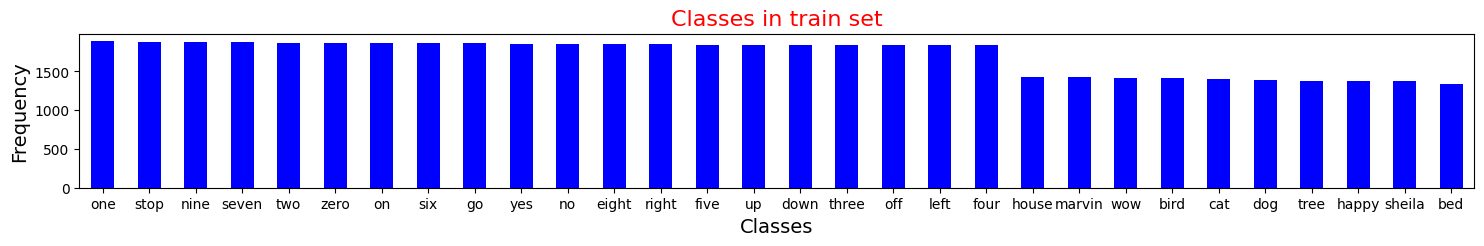

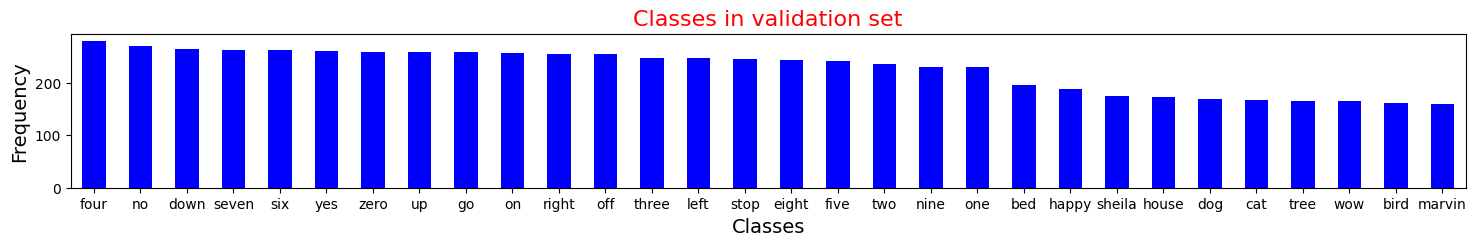

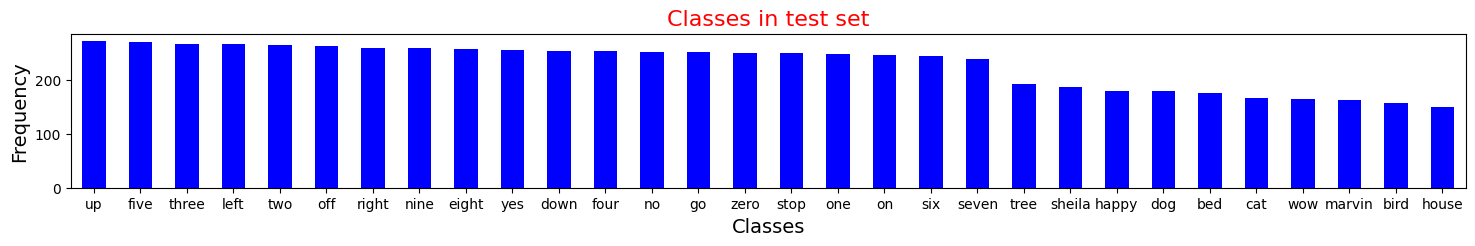

In [15]:
plot_class_histograms(train_df, validation_df, test_df)

As we can see the datasets are pretty balanced.

In [16]:
def plot_duration_histograms(train_df, validation_df, test_df):
    # Creazione della figura e degli assi
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Istogramma per il primo DataFrame
    axs[0].hist(train_df['duration'], bins=30, color='blue', alpha=0.7)
    axs[0].set_title('Durations in train set')
    axs[0].set_xlabel('Duration')
    axs[0].set_ylabel('Frequency')

    # Istogramma per il secondo DataFrame
    axs[1].hist(validation_df['duration'], bins=30, color='green', alpha=0.7)
    axs[1].set_title('Durations in validation set')
    axs[1].set_xlabel('Duration')
    axs[1].set_ylabel('Frequency')

    # Istogramma per il terzo DataFrame
    axs[2].hist(test_df['duration'], bins=30, color='red', alpha=0.7)
    axs[2].set_title('Durations test set')
    axs[2].set_xlabel('Duration')
    axs[2].set_ylabel('Frequency')

    # Aggiunta di un titolo generale
    plt.suptitle('Histogram of Durations in the dataset', color='red')

    # Mostra la figura
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Aggiusta il layout
    plt.show()

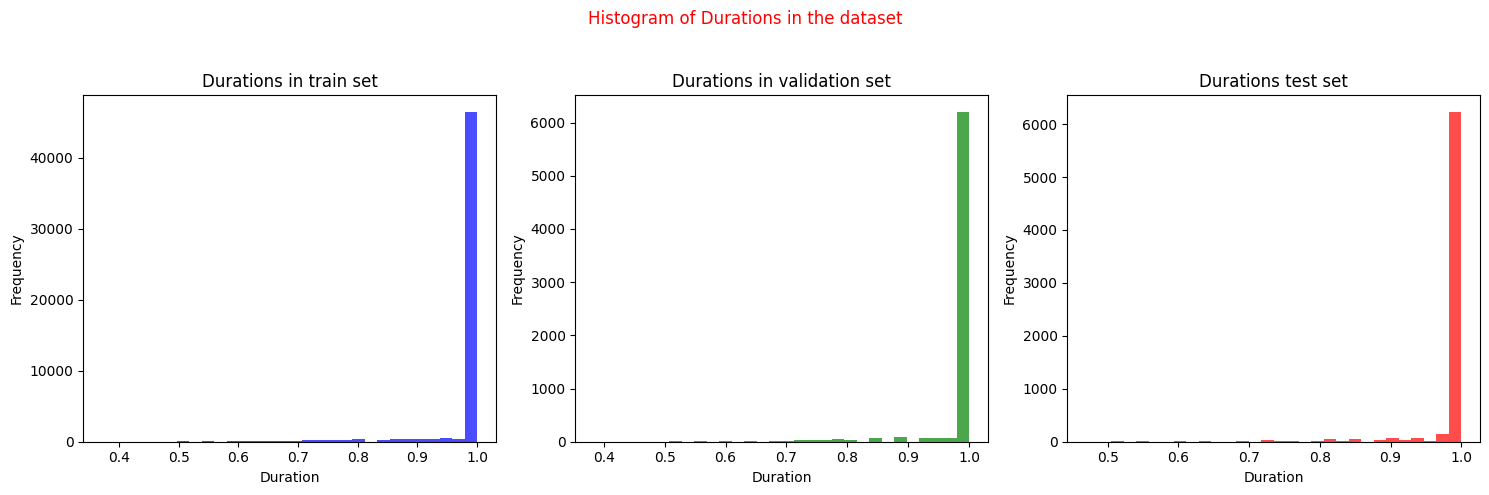

In [17]:
plot_duration_histograms(train_df, validation_df, test_df)

As we can see some audio don't have the duration of 1 second. So, it is clear that we need to zero pad them in order to have similar MFCC to give as input to our model.

In [18]:
def play_random_audio_and_plot_waveform_mfcc_stft(df):
    """
    Select a random audio from the DataFrame, play it,
    and plot the waveform, MFCC spectrogram, and STFT spectrogram.
    """
    # Seleziona un percorso casuale dalla colonna 'path'
    random_index = random.choice(df.index)
    audio_path = df.loc[random_index, 'path']

    # Carica l'audio con librosa
    audio_data, sample_rate = librosa.load(audio_path)

    # Riproduci l'audio
    display(Audio(audio_path, rate=sample_rate))

    # Stampa la waveform
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(audio_data, sr=sample_rate, color='blue')
    plt.title(f'Waveform of audio: {audio_path}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.show()

    # Calcola e stampa lo spettrogramma MFCC
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=13)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time', cmap='coolwarm')
    plt.title(f'MFCC Spectrogram of audio: {audio_path}')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)')
    plt.ylabel('MFCC Coefficients')
    plt.grid()
    plt.show()

    # Calcola e stampa lo spettrogramma STFT
    D = librosa.stft(audio_data)
    S_db = librosa.amplitude_to_db(abs(D), ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_db, sr=sample_rate, x_axis='time', y_axis='log', cmap='coolwarm')
    plt.title(f'STFT Spectrogram of audio: {audio_path}')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.grid()
    plt.show()

    # Restituisce il percorso audio scelto
    return audio_path

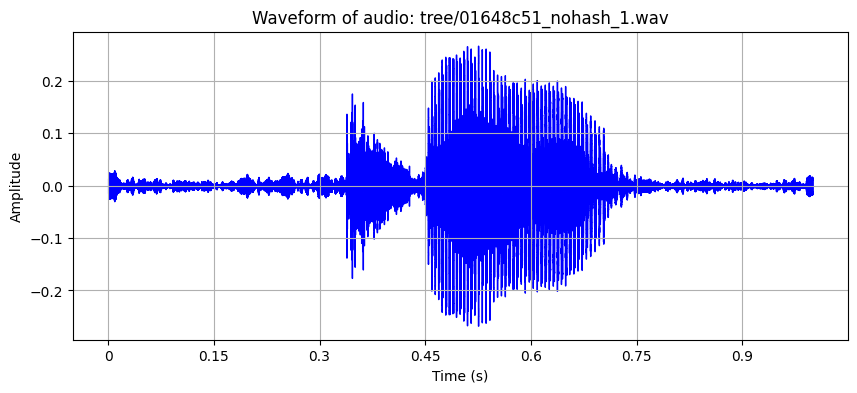

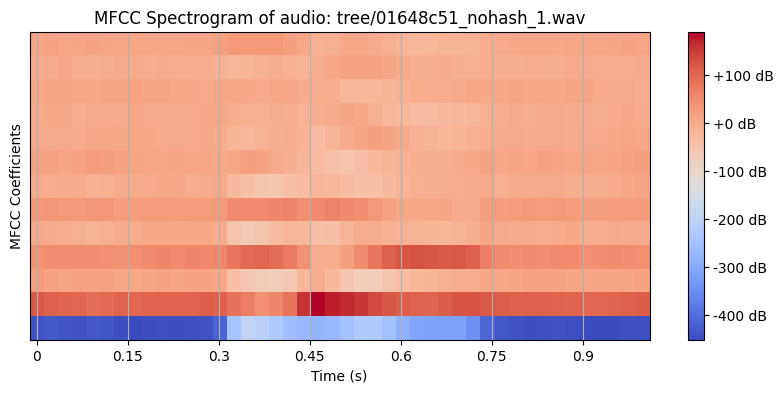

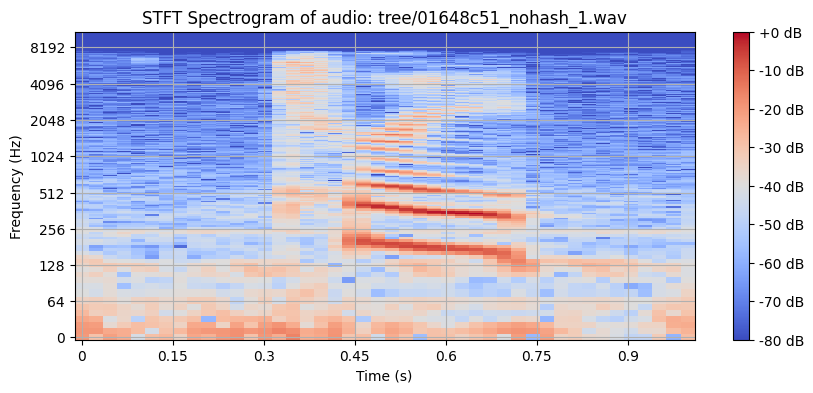

In [19]:
casual_audio_path = play_random_audio_and_plot_waveform_mfcc_stft(train_df)

# Features Extraction and Engineering

Not all our audio present a duration equal to 1.0 second. So, we need to zero-pad their waveforms in order to have Spectrograms with similar dimensions.

Also, the spectrograms are 2D arrays, thus, we can use them as input to a convolutional model in order to perform audio classification.

In [20]:
def add_waveform_column(df, target_duration, sample_rate = 16000):
    """
    Aggiunge una colonna 'waveform' al DataFrame contenente le waveforms degli audio.
    Le waveforms vengono zero-paddate per avere una durata uguale a 'target_duration'.

    Parameters:
    - df: DataFrame contenente i percorsi audio nella colonna 'path'.
    - target_duration: Durata target in secondi per le waveforms.
    - sample_rate: Frequenza di campionamento dell'audio (default è 16000).

    Returns:
    - df: DataFrame aggiornato con la colonna 'waveform'.
    """

    # Calcola il numero di campioni per la durata target
    target_samples = int(target_duration * sample_rate)

    # Aggiunge la colonna 'waveform'
    waveforms = []

    for index, row in df.iterrows():
        audio_path = row['path']

        # Carica l'audio
        audio_data, sr = librosa.load(audio_path, sr=sample_rate)

        # Zero-padding se necessario
        if len(audio_data) < target_samples:
            # Aggiungi zero-padding
            padded_waveform = np.pad(audio_data, (0, target_samples - len(audio_data)), mode='constant')
        else:
            # Trunca l'audio se è più lungo della durata target
            padded_waveform = audio_data[:target_samples]

        waveforms.append(padded_waveform)

    # Aggiungi la lista delle waveforms come nuova colonna
    df['waveform'] = waveforms

    return df

In [21]:
sample_rate = 16000
train_df = add_waveform_column(train_df, target_duration=1.0, sample_rate = sample_rate)
validation_df = add_waveform_column(validation_df, target_duration=1.0, sample_rate = sample_rate)
test_df = add_waveform_column(test_df, target_duration=1.0, sample_rate = sample_rate)

In [22]:
def add_mfcc_column(df, sample_rate = 16000):
    """
    Aggiunge una colonna 'mfcc' al DataFrame contenente i coefficienti MFCC delle waveforms.

    Parameters:
    - df: DataFrame contenente le waveforms nella colonna 'waveform'.
    - n_mfcc: Numero di coefficienti MFCC da calcolare (default è 13).

    Returns:
    - df: DataFrame aggiornato con la colonna 'mfcc'.
    """
    mfccs_list = []

    for index, row in df.iterrows():
        waveform = row['waveform']

        # Calcola i coefficienti MFCC
        mfccs = librosa.feature.mfcc(y=waveform, sr=sample_rate)

        # Aggiungi i MFCC alla lista
        mfccs_list.append(mfccs)

    # Aggiungi la lista dei MFCC come nuova colonna
    df['mfcc'] = mfccs_list

    return df

In [23]:
train_df = add_mfcc_column(train_df, sample_rate = sample_rate)
validation_df = add_mfcc_column(validation_df, sample_rate = sample_rate)
test_df = add_mfcc_column(validation_df, sample_rate = sample_rate)

In [24]:
print("Number of elements in train dataframe:", len(train_df))
print("Number of elements in validation dataframe:", len(validation_df))
print("Number of elements in test dataframe:", len(test_df))

Number of elements in train dataframe: 51088
Number of elements in validation dataframe: 6798
Number of elements in test dataframe: 6798


# Input Data Creation

In [25]:
def create_tf_dataset(df):
    """
    Creates a TensorFlow dataset from a DataFrame.

    Parameters:
    - df: DataFrame containing the columns 'mfcc' and 'class'.

    Returns:
    - dataset: TensorFlow Dataset containing the data and labels.
    """

    # Extract the data and labels from the DataFrame
    mfccs = df['mfcc'].tolist()  # List of MFCC features
    labels = df['class'].tolist()  # List of class labels

    # Convert string labels to numerical values
    label_encoder = LabelEncoder()  # Initialize the label encoder
    labels_encoded = label_encoder.fit_transform(labels)  # Encode labels

    # Convert the numerical labels to one-hot encoding
    labels_one_hot = to_categorical(labels_encoded, num_classes=30)  # One-hot encode the labels

    # Create the TensorFlow dataset from the MFCC features and one-hot encoded labels
    dataset = tf.data.Dataset.from_tensor_slices((mfccs, labels_one_hot))

    return dataset  # Return the created TensorFlow dataset

In [26]:
train_ds = create_tf_dataset(train_df).shuffle(buffer_size = 10000)
validation_ds = create_tf_dataset(validation_df).shuffle(buffer_size = 10000)
test_ds = create_tf_dataset(test_df).shuffle(buffer_size = 10000)

In [27]:
def add_channel_dimension(mfcc, label):
    mfcc_with_channel = tf.expand_dims(mfcc, axis=-1)
    return mfcc_with_channel, label

In [28]:
train_ds = train_ds.map(add_channel_dimension)
validation_ds = validation_ds.map(add_channel_dimension)
test_ds = test_ds.map(add_channel_dimension)

In [29]:
count = train_ds.reduce(0, lambda x, _: x + 1).numpy()
print("Number of elements in train dataset:", count)
count = validation_ds.reduce(0, lambda x, _: x + 1).numpy()
print("Number of elements in validation dataset:", count)
count = test_ds.reduce(0, lambda x, _: x + 1).numpy()
print("Number of elements in test dataset:", count)

Number of elements in train dataset: 51088
Number of elements in validation dataset: 6798
Number of elements in test dataset: 6798


# Some Usefull functions for our models

In [30]:
def plot_model_history(history, title=""):
    """
    Plots the training history of a Keras model.

    Parameters:
    - history: A Keras History object containing training metrics.
    - title: (Optional) A string to set the title of the plot.
    """

    # Extract values from the history object
    loss = history.history['loss']  # Training loss values
    val_loss = history.history['val_loss']  # Validation loss values
    accuracy = history.history['accuracy']  # Training accuracy values
    val_accuracy = history.history['val_accuracy']  # Validation accuracy values
    f1_score = history.history['f1_score']  # Training F1 score values
    val_f1_score = history.history['val_f1_score']  # Validation F1 score values

    # Create the figure
    plt.figure(figsize=(15, 10))

    # Plot 1: Categorical Crossentropy Loss
    plt.subplot(3, 1, 1)
    plt.plot(loss, label='Train Loss')  # Plot training loss
    plt.plot(val_loss, label='Validation Loss')  # Plot validation loss
    plt.title('Categorical Crossentropy Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot 2: Accuracy
    plt.subplot(3, 1, 2)
    plt.plot(accuracy, label='Train Accuracy')  # Plot training accuracy
    plt.plot(val_accuracy, label='Validation Accuracy')  # Plot validation accuracy
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot 3: F1 Score
    plt.subplot(3, 1, 3)
    plt.plot(f1_score, label='Train F1 Score')  # Plot training F1 score
    plt.plot(val_f1_score, label='Validation F1 Score')  # Plot validation F1 score
    plt.title('F1 Score')
    plt.ylabel('F1 Score')
    plt.xlabel('Epoch')
    plt.legend()

    plt.suptitle(title, fontsize=16, color='red')  # Set the overall title
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()  # Display the plots

In [138]:
def plot_confusion_matrix(model, test_ds, class_names, title=""):
    test_audio = []
    test_labels = []

    for audio, label in test_ds:
        # Collect the audio and labels as numpy arrays
        test_audio.append(audio.numpy())  # appending batch data
        test_labels.append(label.numpy())  # appending labels for the batch

    # Convert the list of batches into a single numpy array
    test_audio = np.concatenate(test_audio, axis=0)  # Combine along batch dimension
    test_labels = np.concatenate(test_labels, axis=0)  # Combine labels

    # Make predictions
    y_pred = np.argmax(model.predict(test_audio), axis=1)  # Predicted class labels
    y_true = test_labels.argmax(axis=1)  # True class labels (if one-hot encoded)

    # Generate confusion matrix
    confusion_mtx = confusion_matrix(y_true, y_pred)
    confusion_mtx_normalized = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]

    # Plot the confusion matrices
    fig, axes = plt.subplots(2, 1, figsize=(15, 20))  # Cambiato a 2 righe e 1 colonna

    # Non-normalized confusion matrix
    sns.heatmap(confusion_mtx,
                xticklabels=class_names,
                yticklabels=class_names,
                annot=True, fmt='g', ax=axes[0])
    axes[0].set_xlabel('Prediction')
    axes[0].set_ylabel('Label')
    axes[0].set_title(f'{title} - Non-Normalized', color="blue")

    # Normalized confusion matrix
    sns.heatmap(confusion_mtx_normalized,
                xticklabels=class_names,
                yticklabels=class_names,
                annot=True, fmt='.2f', ax=axes[1])
    axes[1].set_xlabel('Prediction')
    axes[1].set_ylabel('Label')
    axes[1].set_title(f'{title} - Normalized', color="blue")

    plt.suptitle(title, fontsize=16, color="red")
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
    plt.show()

# Model Creation

In this section we are going to create our CNN model in order to classify our MFCCs.
But, firstly, we need to define some constants that we are going to use...

Note that, since our 2D input tensors are audio features we don't need to preserve theier aspect ration. So, we can try to resize them in a more easy-to-use format. Thus, the first layer of our architecture is going to be a Resizing layer.

In [32]:
NUM_CLASSES = len(class_list)
INPUT_SHAPE = train_ds.element_spec[0].shape
TARGET_SHAPE = (32, 32)
BATCH_SIZE = 32

## Model 1: "the Simplest Baseline"

In honor of Occam's Razor we start implementing probably the simplest possible model.

This model will have the following structure:

CONV -> ReLU -> MaxPool -> FC -> ReLU -> FC

Probably this model will be not enough to catch the complexity in our input audios. But, it could be a good starting point.

In [33]:
# WE BATCH OUT TENSORFLOW DATASETS IF NECESSARY
if train_ds.element_spec[0].shape != (None, 20, 32, 1):
  train_ds = train_ds.batch(BATCH_SIZE)
if validation_ds.element_spec[0].shape != (None, 20, 32, 1):
  validation_ds = validation_ds.batch(BATCH_SIZE)
if test_ds.element_spec[0].shape != (None, 20, 32, 1):
  test_ds = test_ds.batch(BATCH_SIZE)

In [34]:
# MODEL1: CONV -> ReLU -> MaxPool -> FC -> ReLU -> FC
model1 = Sequential([
    Input(shape=INPUT_SHAPE),
    Resizing(TARGET_SHAPE[0], TARGET_SHAPE[1]),

    Conv2D(16, 3,  activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax'),
])

In the following we can see that this model is really tiny, thus it will be fastly trainable. But also, poor in terms of accuracy.

In [35]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 30, 30, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │         360,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 30)                  │           3,030 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 363,290 (1.39 MB)

 Trainable params: 363,290 (1.39 MB)

 Non-trainable params: 0 (0.00 B)

Now, we are going to use as optimizer AdamW because is seems to better work with images.

While, as loss we are going to use, obviously, a Categorical Crossentropy loss.

Also, we will print as metrics the accuracy and the averaged F1-Score.

In [36]:
model1.compile(
    optimizer = tf.keras.optimizers.AdamW(),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy',
             tf.keras.metrics.F1Score(average='weighted', name='f1_score')],
)

We want to take under controll the validation loss in order to decide when stop the training process due to none improvement.

In [37]:
model1_es = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                             min_delta=0.001,
                                             verbose=1,
                                             patience=3,
                                             restore_best_weights=True)

Now, we can start the training process.

In [38]:
EPOCHS = 25
history1 = model1.fit(
    train_ds,
    validation_data = validation_ds,
    epochs = EPOCHS,
    callbacks=model1_es
)

Epoch 1/25
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.4321 - f1_score: 0.4288 - loss: 3.4241 - val_accuracy: 0.2561 - val_f1_score: 0.1845 - val_loss: 2.8857
Epoch 2/25
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.4475 - f1_score: 0.4414 - loss: 1.7983 - val_accuracy: 0.3276 - val_f1_score: 0.2578 - val_loss: 2.7436
Epoch 3/25
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6022 - f1_score: 0.6022 - loss: 1.2572 - val_accuracy: 0.4395 - val_f1_score: 0.3845 - val_loss: 2.1099
Epoch 4/25
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6953 - f1_score: 0.6971 - loss: 0.9625 - val_accuracy: 0.5025 - val_f1_score: 0.4672 - val_loss: 1.7761
Epoch 5/25
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7287 - f1_score: 0.7313 - loss: 0.8636 - val_accuracy: 0.4962 - val_f1_score: 0.4690 - val_loss: 1.8072
Epoch 6/25
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7598 - f1_score: 0.7637 - loss: 0.7778 - val_accuracy: 0.5199 - val

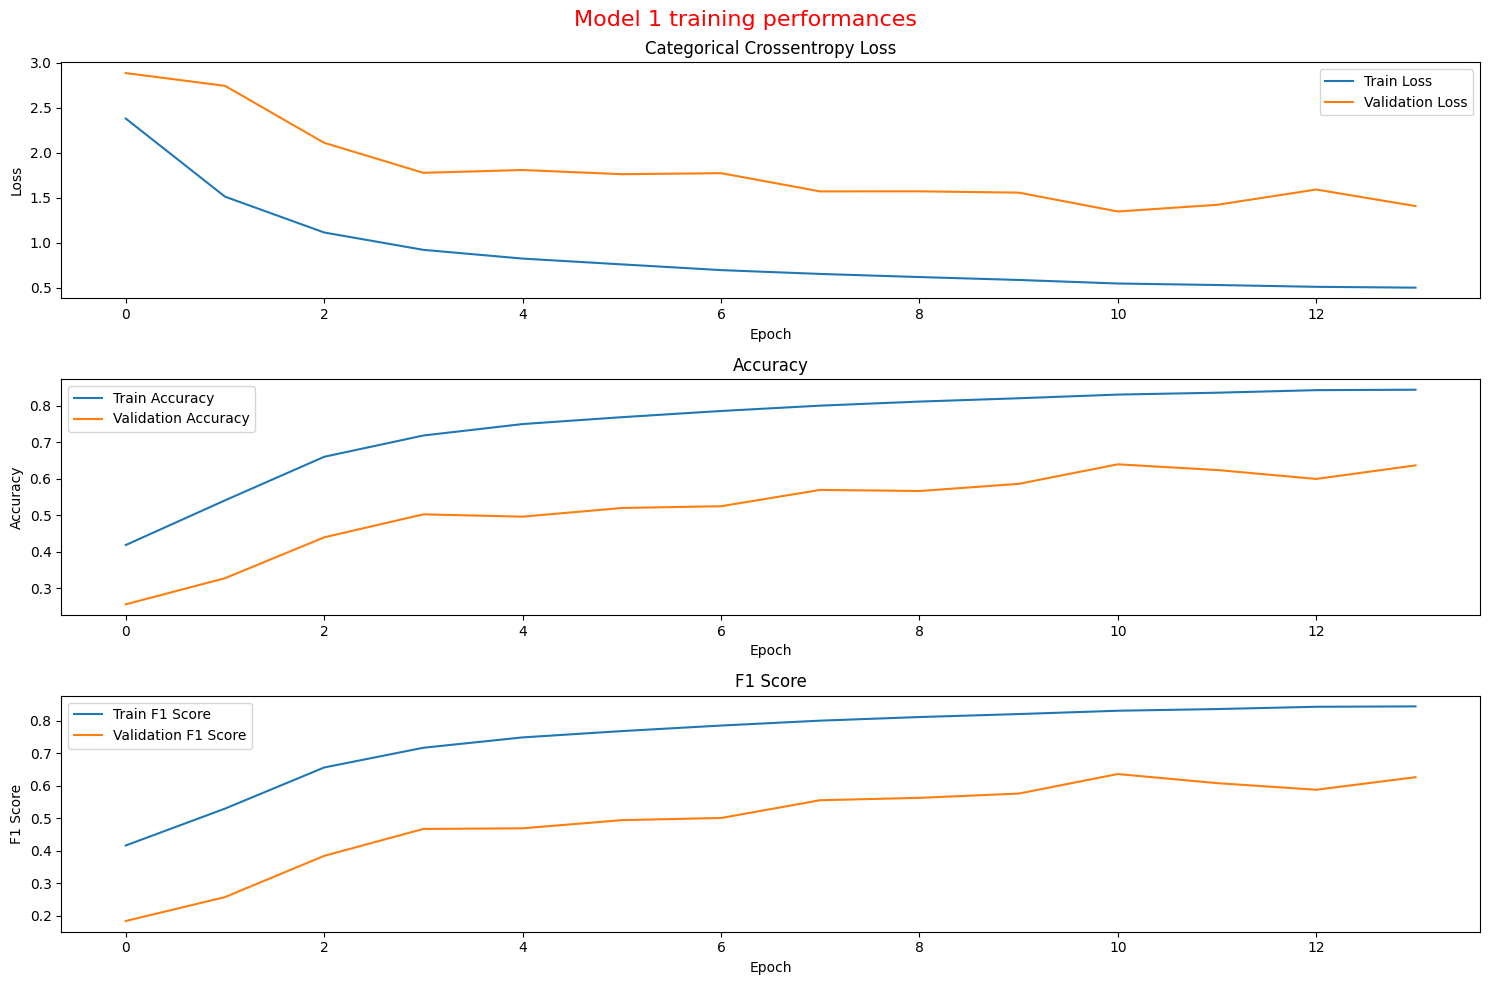

In [39]:
plot_model_history(history1, "Model 1 training performances")

Above we can see that this simple model is not so bad, it is a good starting point. But it tends to overfit our training data!

In [40]:
model1_test_metrics = model1.evaluate(test_ds,
                                      verbose=2,
                                      return_dict=True)

213/213 - 1s - 3ms/step - accuracy: 0.6395 - f1_score: 0.6357 - loss: 1.3459


213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


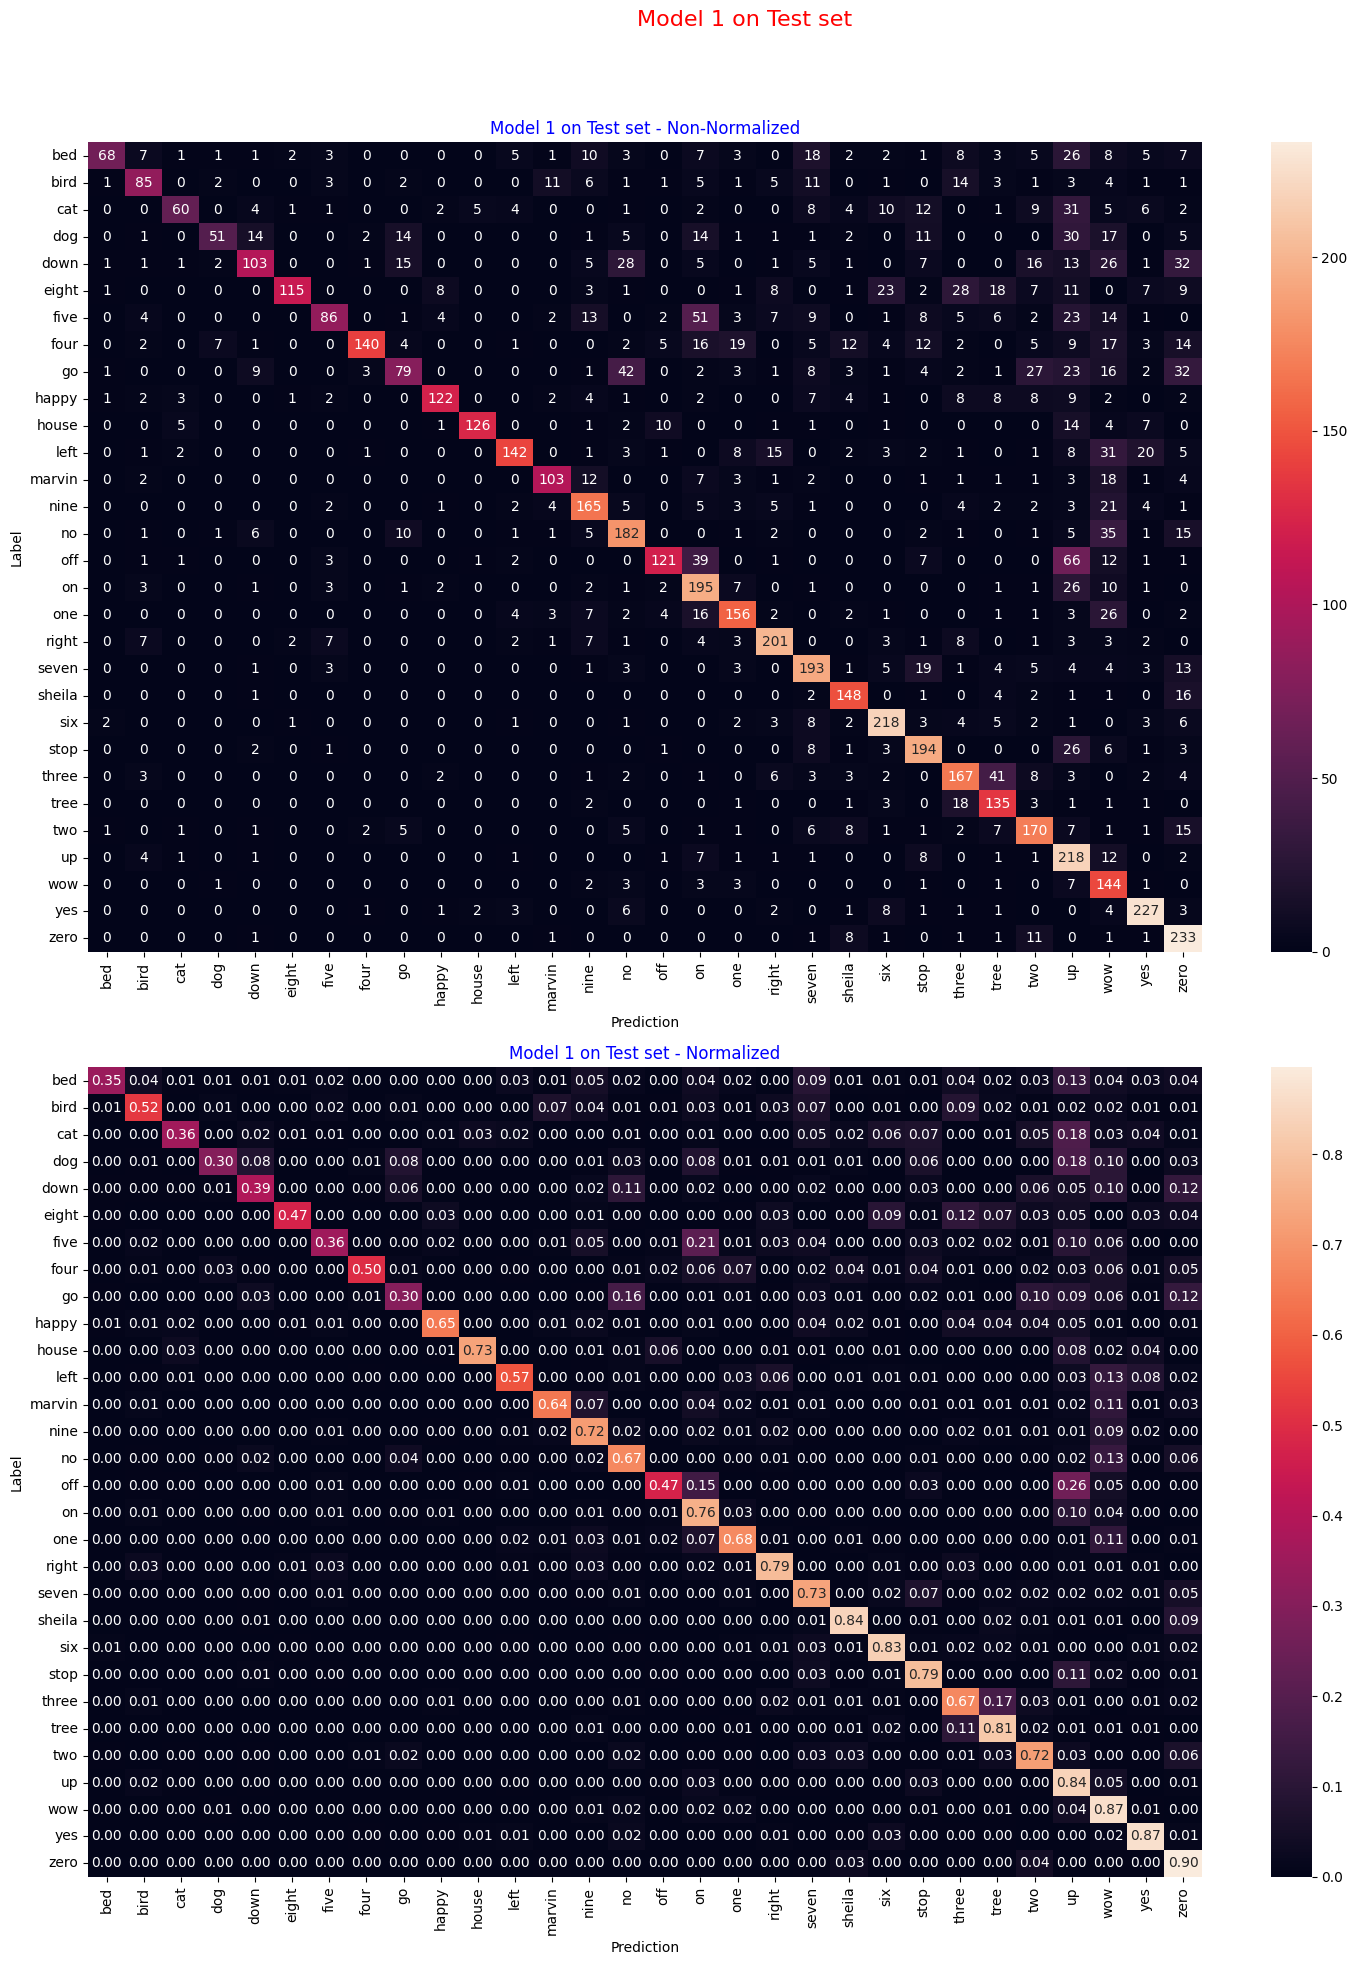

In [140]:
plot_confusion_matrix(model1, test_ds, class_list, title="Model 1 on Test set")

This simple model is a good baseline, but the number of missclassifications is too high. So, we want to try to improve it.

## Model 2: "adding Batch Normalization"

Since Model 1 tends to overfit, we are going to add to it a Batch Normalization layer after the Max Pooling one.

The Batch Normalization layer should be able to add some noise to the network activations, serving as a regularization technique. This noise aids in averting overfitting by injecting randomness.

Now, the problem is: where should we put the normalization layer? Since we use ReLU as activation function we try to put Batch Normalization before the activation as suggested by [the original batch normalization paper](https://arxiv.org/pdf/1502.03167).

Thus, our Model 2 architecture will be:

CONV -> BN -> ReLU -> MaxPool -> FC -> ReLU -> FC

In [42]:
# WE BATCH OUT TENSORFLOW DATASETS IF NECESSARY
if train_ds.element_spec[0].shape != (None, 20, 32, 1):
  train_ds = train_ds.batch(BATCH_SIZE)
if validation_ds.element_spec[0].shape != (None, 20, 32, 1):
  validation_ds = validation_ds.batch(BATCH_SIZE)
if test_ds.element_spec[0].shape != (None, 20, 32, 1):
  test_ds = test_ds.batch(BATCH_SIZE)

In [78]:
# MODEL2: CONV -> BN -> ReLU -> MaxPool -> FC -> ReLU -> FC
model2 = Sequential([
    Input(shape=INPUT_SHAPE),
    Resizing(TARGET_SHAPE[0], TARGET_SHAPE[1]),

    Conv2D(16, 3,  activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(100, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax'),
])

In [79]:
model2.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_5 (Resizing)                │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 30, 30, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 30, 30, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 15, 15, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 3600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 100)                 │         360,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 30)                  │           3,030 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 363,354 (1.39 MB)

 Trainable params: 363,322 (1.39 MB)

 Non-trainable params: 32 (128.00 B)

In [80]:
model2.compile(
    optimizer = tf.keras.optimizers.AdamW(),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy',
             tf.keras.metrics.F1Score(average='weighted', name='f1_score')],
)

In [81]:
model2_es = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                             min_delta=0.001,
                                             verbose=1,
                                             patience=4,
                                             restore_best_weights=True)

In [82]:
EPOCHS = 20
history2 = model2.fit(
    train_ds,
    validation_data = validation_ds,
    epochs = EPOCHS,
    callbacks = model2_es
)

Epoch 1/20
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.4830 - f1_score: 0.4763 - loss: 1.6980 - val_accuracy: 0.4028 - val_f1_score: 0.3390 - val_loss: 2.3627
Epoch 2/20
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6648 - f1_score: 0.6667 - loss: 1.0990 - val_accuracy: 0.5165 - val_f1_score: 0.4805 - val_loss: 1.7786
Epoch 3/20
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7547 - f1_score: 0.7580 - loss: 0.7943 - val_accuracy: 0.5796 - val_f1_score: 0.5750 - val_loss: 1.5033
Epoch 4/20
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7920 - f1_score: 0.7955 - loss: 0.6627 - val_accuracy: 0.6006 - val_f1_score: 0.5870 - val_loss: 1.4489
Epoch 5/20
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8126 - f1_score: 0.8159 - loss: 0.5999 - val_accuracy: 0.6353 - val_f1_score: 0.6328 - val_loss: 1.2771
Epoch 6/20
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8313 - f1_score: 0.8344 - loss: 0.5439 - val_accuracy: 0.6433 - val_f1_

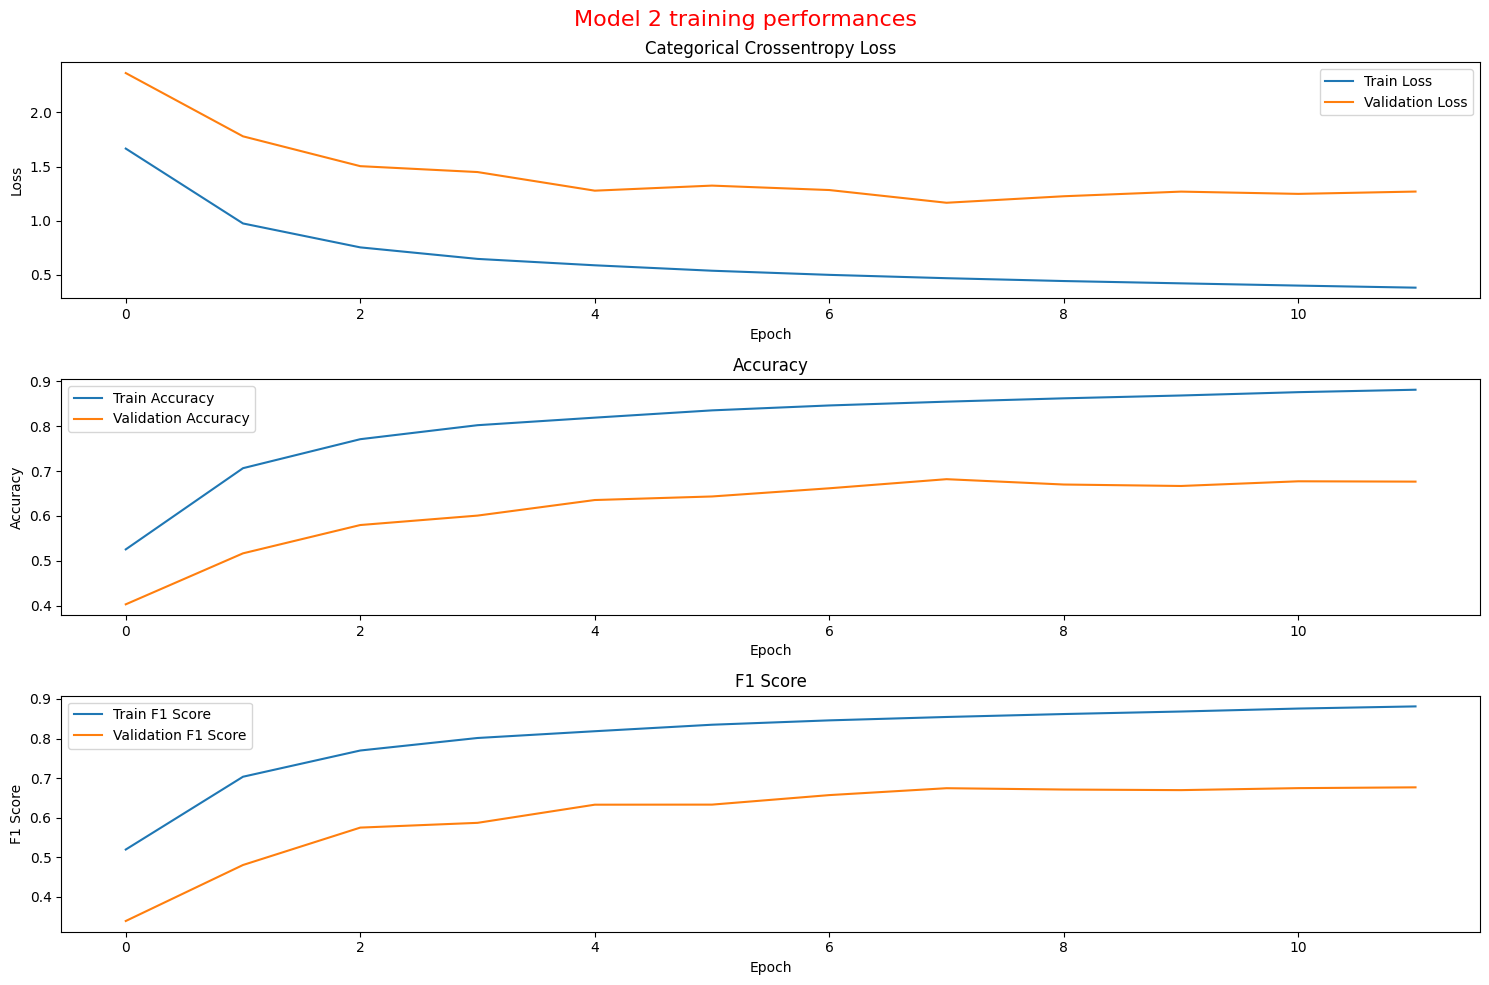

In [83]:
plot_model_history(history2, "Model 2 training performances")

In [84]:
model2_test_metrics = model2.evaluate(test_ds,
                                      verbose=2,
                                      return_dict=True)

213/213 - 1s - 3ms/step - accuracy: 0.6818 - f1_score: 0.6745 - loss: 1.1655


213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


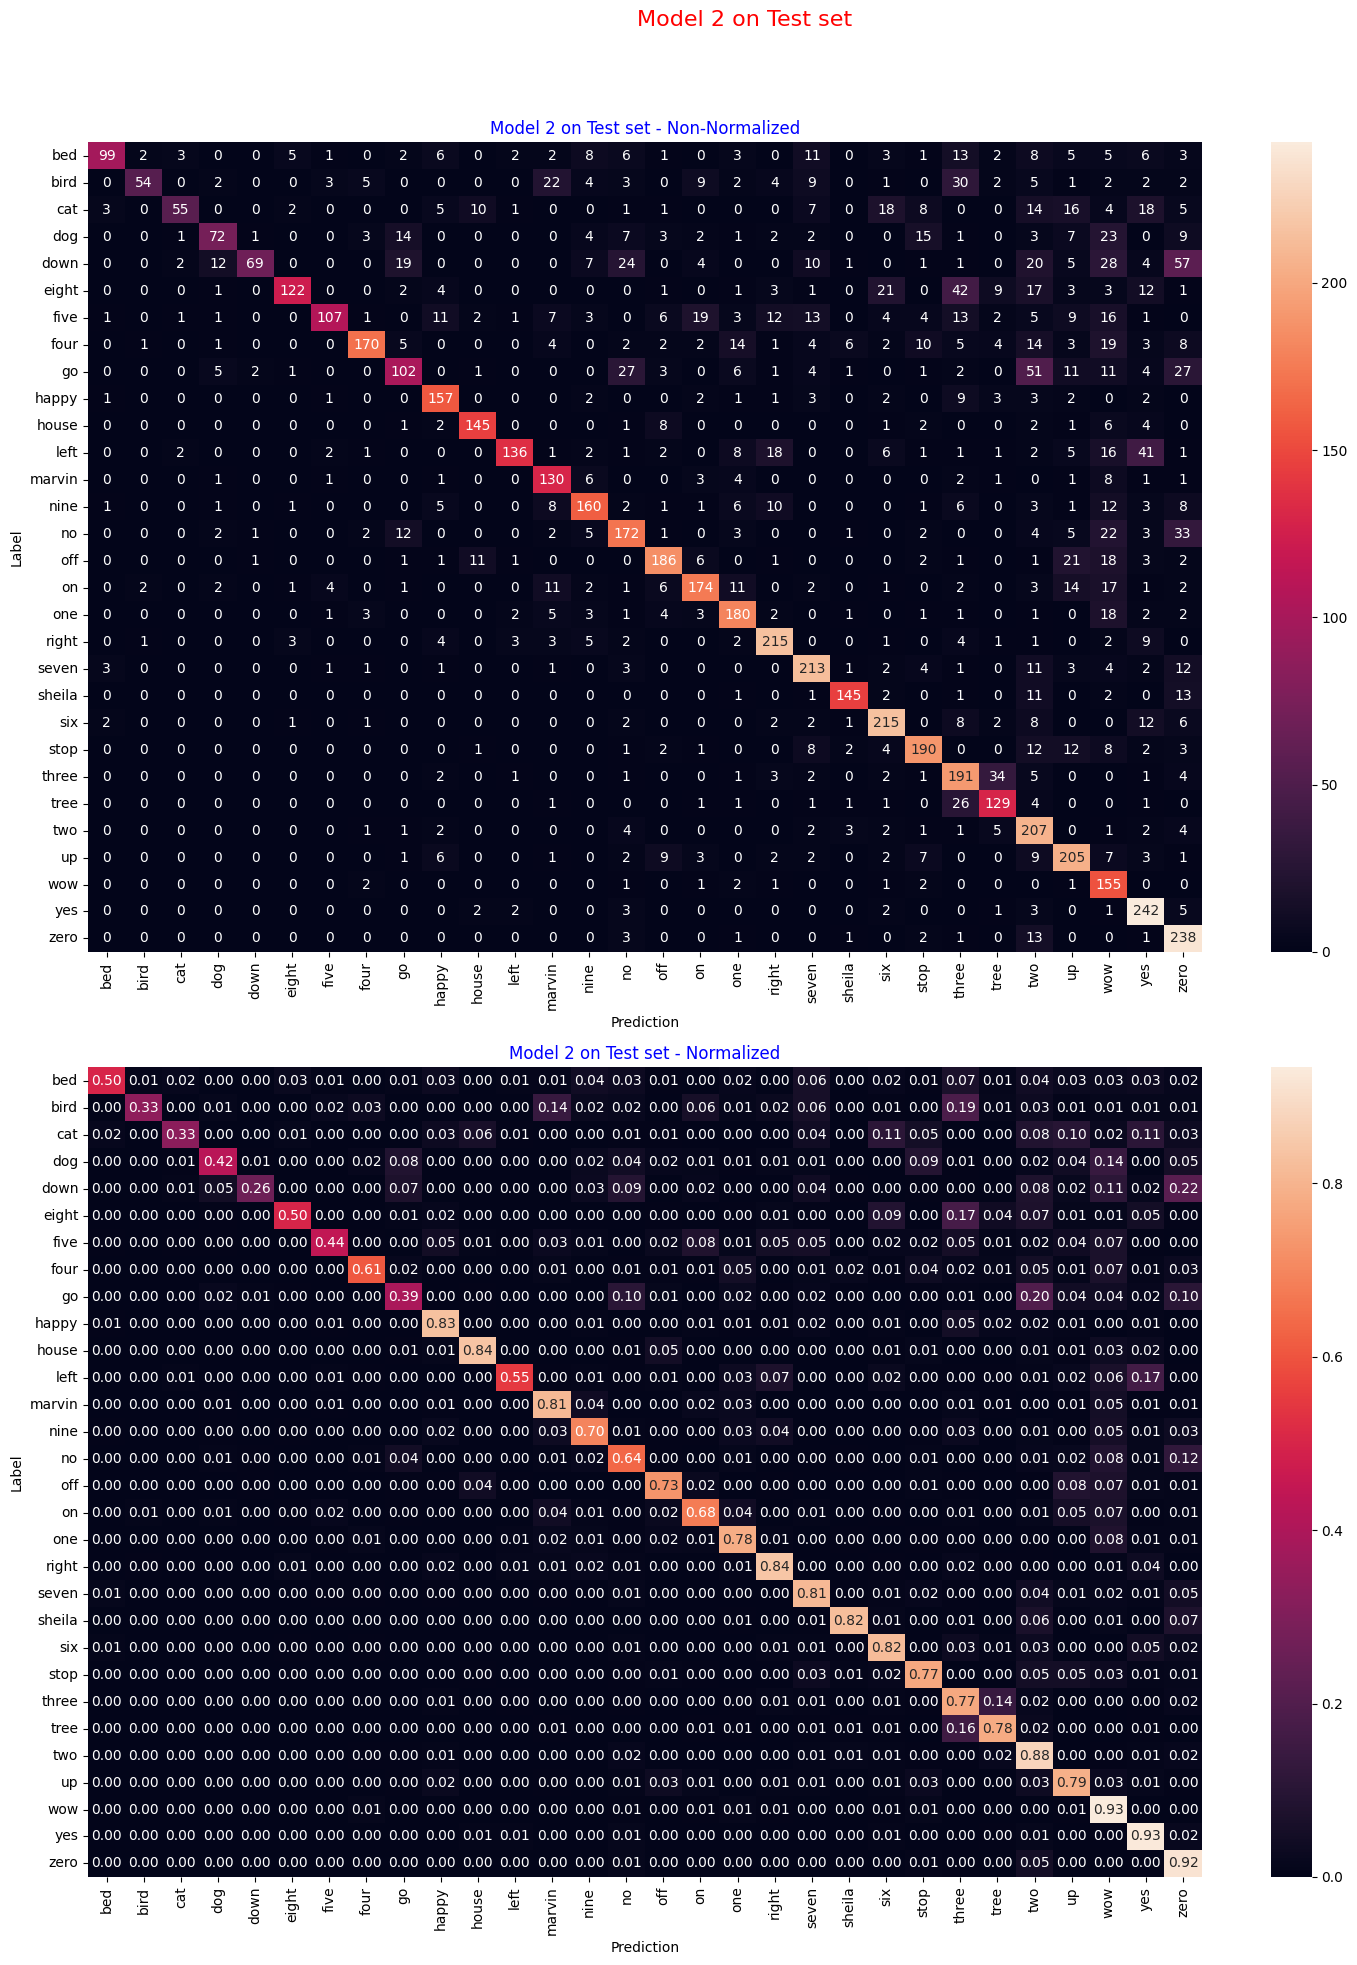

In [141]:
plot_confusion_matrix(model2, test_ds, class_list, title="Model 2 on Test set")

Not bad, with just one single Batch Normalization layer we obtained a good improvement!

## Model 3: "one more Convolutional Block"

Now we want to improve more our model performances. So, since the pattern: Conv2D + BN works, we are going to add another block like this to our network.

In this way we should be able to improve the model generalization ability.

Thus, Model 3 will have the following architecture:

CONV -> BN -> ReLU -> MaxPool ->

CONV -> BN -> ReLU -> MaxPool ->

FC -> ReLU -> FC

In [51]:
# WE BATCH OUT TENSORFLOW DATASETS IF NECESSARY
if train_ds.element_spec[0].shape != (None, 20, 32, 1):
  train_ds = train_ds.batch(BATCH_SIZE)
if validation_ds.element_spec[0].shape != (None, 20, 32, 1):
  validation_ds = validation_ds.batch(BATCH_SIZE)
if test_ds.element_spec[0].shape != (None, 20, 32, 1):
  test_ds = test_ds.batch(BATCH_SIZE)

In [86]:
# MODEL3:
# CONV -> BN -> ReLU -> MaxPool ->
# CONV -> BN -> ReLU -> MaxPool ->
# FC -> ReLU -> FC

model3 = Sequential([
    Input(shape=INPUT_SHAPE),
    Resizing(TARGET_SHAPE[0], TARGET_SHAPE[1]),

    Conv2D(16, 3,  activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),

    Conv2D(32, 3,  activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(100, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax'),
])

In [87]:
model3.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_6 (Resizing)                │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 30, 30, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 30, 30, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 15, 15, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 13, 13, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 13, 13, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 100)                 │         115,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 30)                  │           3,030 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 123,322 (481.73 KB)

 Trainable params: 123,226 (481.35 KB)

 Non-trainable params: 96 (384.00 B)

In [88]:
model3.compile(
    optimizer = tf.keras.optimizers.AdamW(),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy',
             tf.keras.metrics.F1Score(average='weighted', name='f1_score')],
)

In [89]:
model3_es = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                             min_delta=0.001,
                                             verbose=1,
                                             patience=4,
                                             restore_best_weights=True)

In [90]:
EPOCHS = 25
history3 = model3.fit(
                      train_ds,
                      validation_data = validation_ds,
                      epochs = EPOCHS,
                      callbacks = model3_es
                      )

Epoch 1/25
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.5859 - f1_score: 0.5819 - loss: 1.3533 - val_accuracy: 0.5271 - val_f1_score: 0.5008 - val_loss: 1.6765
Epoch 2/25
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8034 - f1_score: 0.8073 - loss: 0.6340 - val_accuracy: 0.6780 - val_f1_score: 0.6826 - val_loss: 1.1165
Epoch 3/25
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.8613 - f1_score: 0.8644 - loss: 0.4547 - val_accuracy: 0.7468 - val_f1_score: 0.7410 - val_loss: 0.8782
Epoch 4/25
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8867 - f1_score: 0.8895 - loss: 0.3646 - val_accuracy: 0.7209 - val_f1_score: 0.7157 - val_loss: 0.9803
Epoch 5/25
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9060 - f1_score: 0.9086 - loss: 0.3058 - val_accuracy: 0.7158 - val_f1_score: 0.7234 - val_loss: 1.0427
Epoch 6/25
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9173 - f1_score: 0.9196 - loss: 0.2682 - val_accuracy: 0.7979 - val_

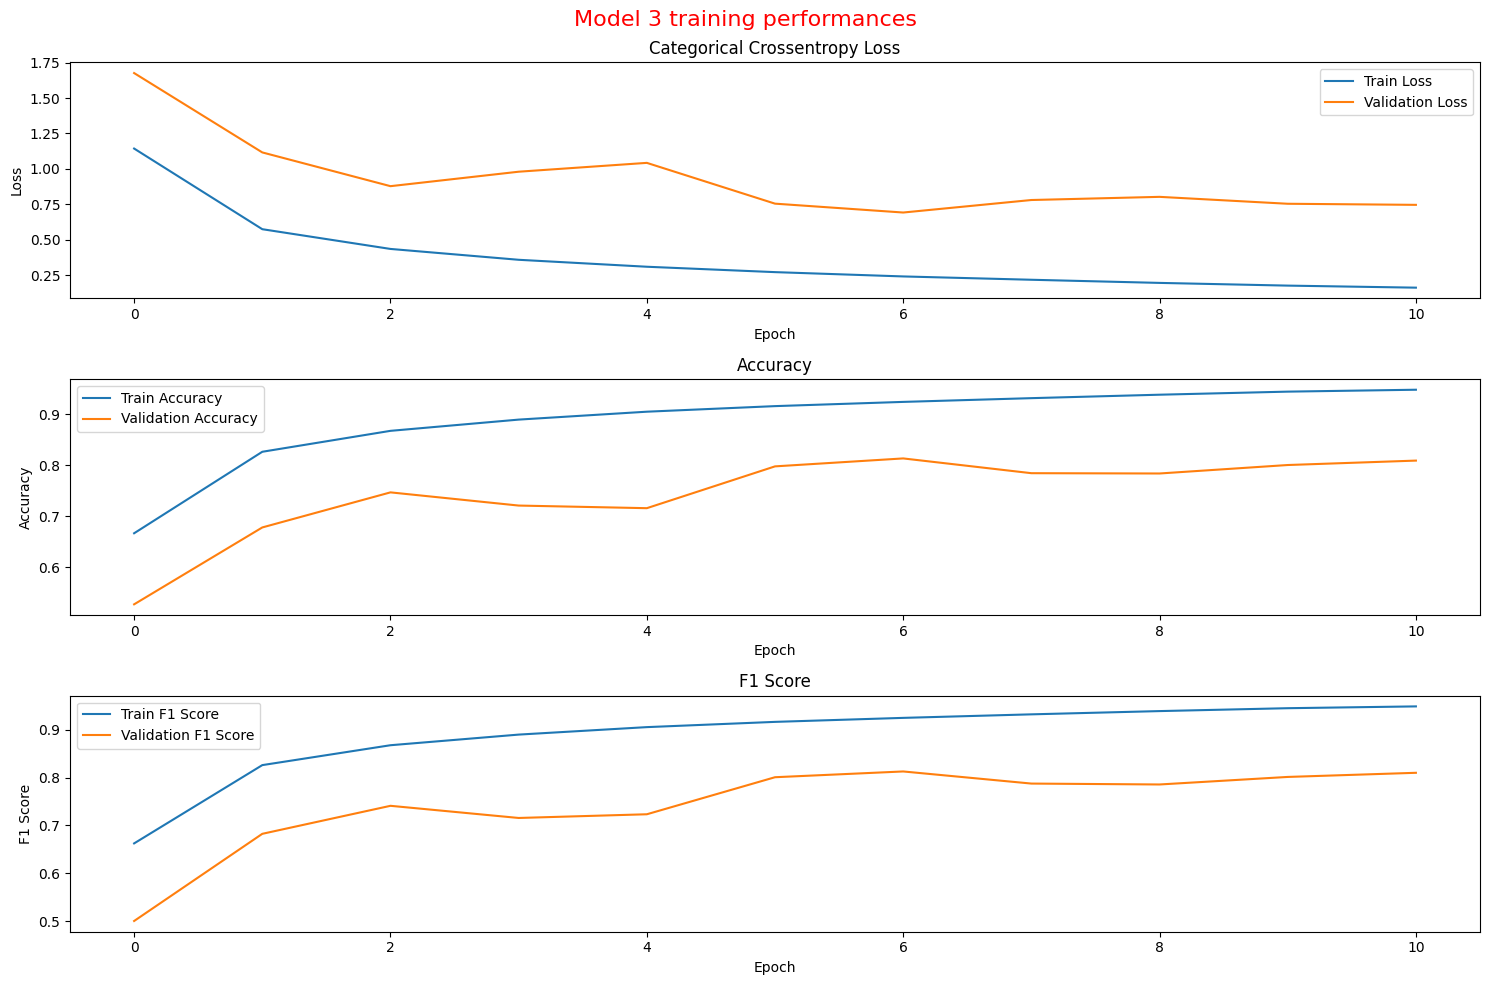

In [91]:
plot_model_history(history3, "Model 3 training performances")

In [92]:
model3_test_metrics = model3.evaluate(test_ds,
                                      verbose=2,
                                      return_dict=True)

213/213 - 1s - 4ms/step - accuracy: 0.8135 - f1_score: 0.8127 - loss: 0.6922


213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


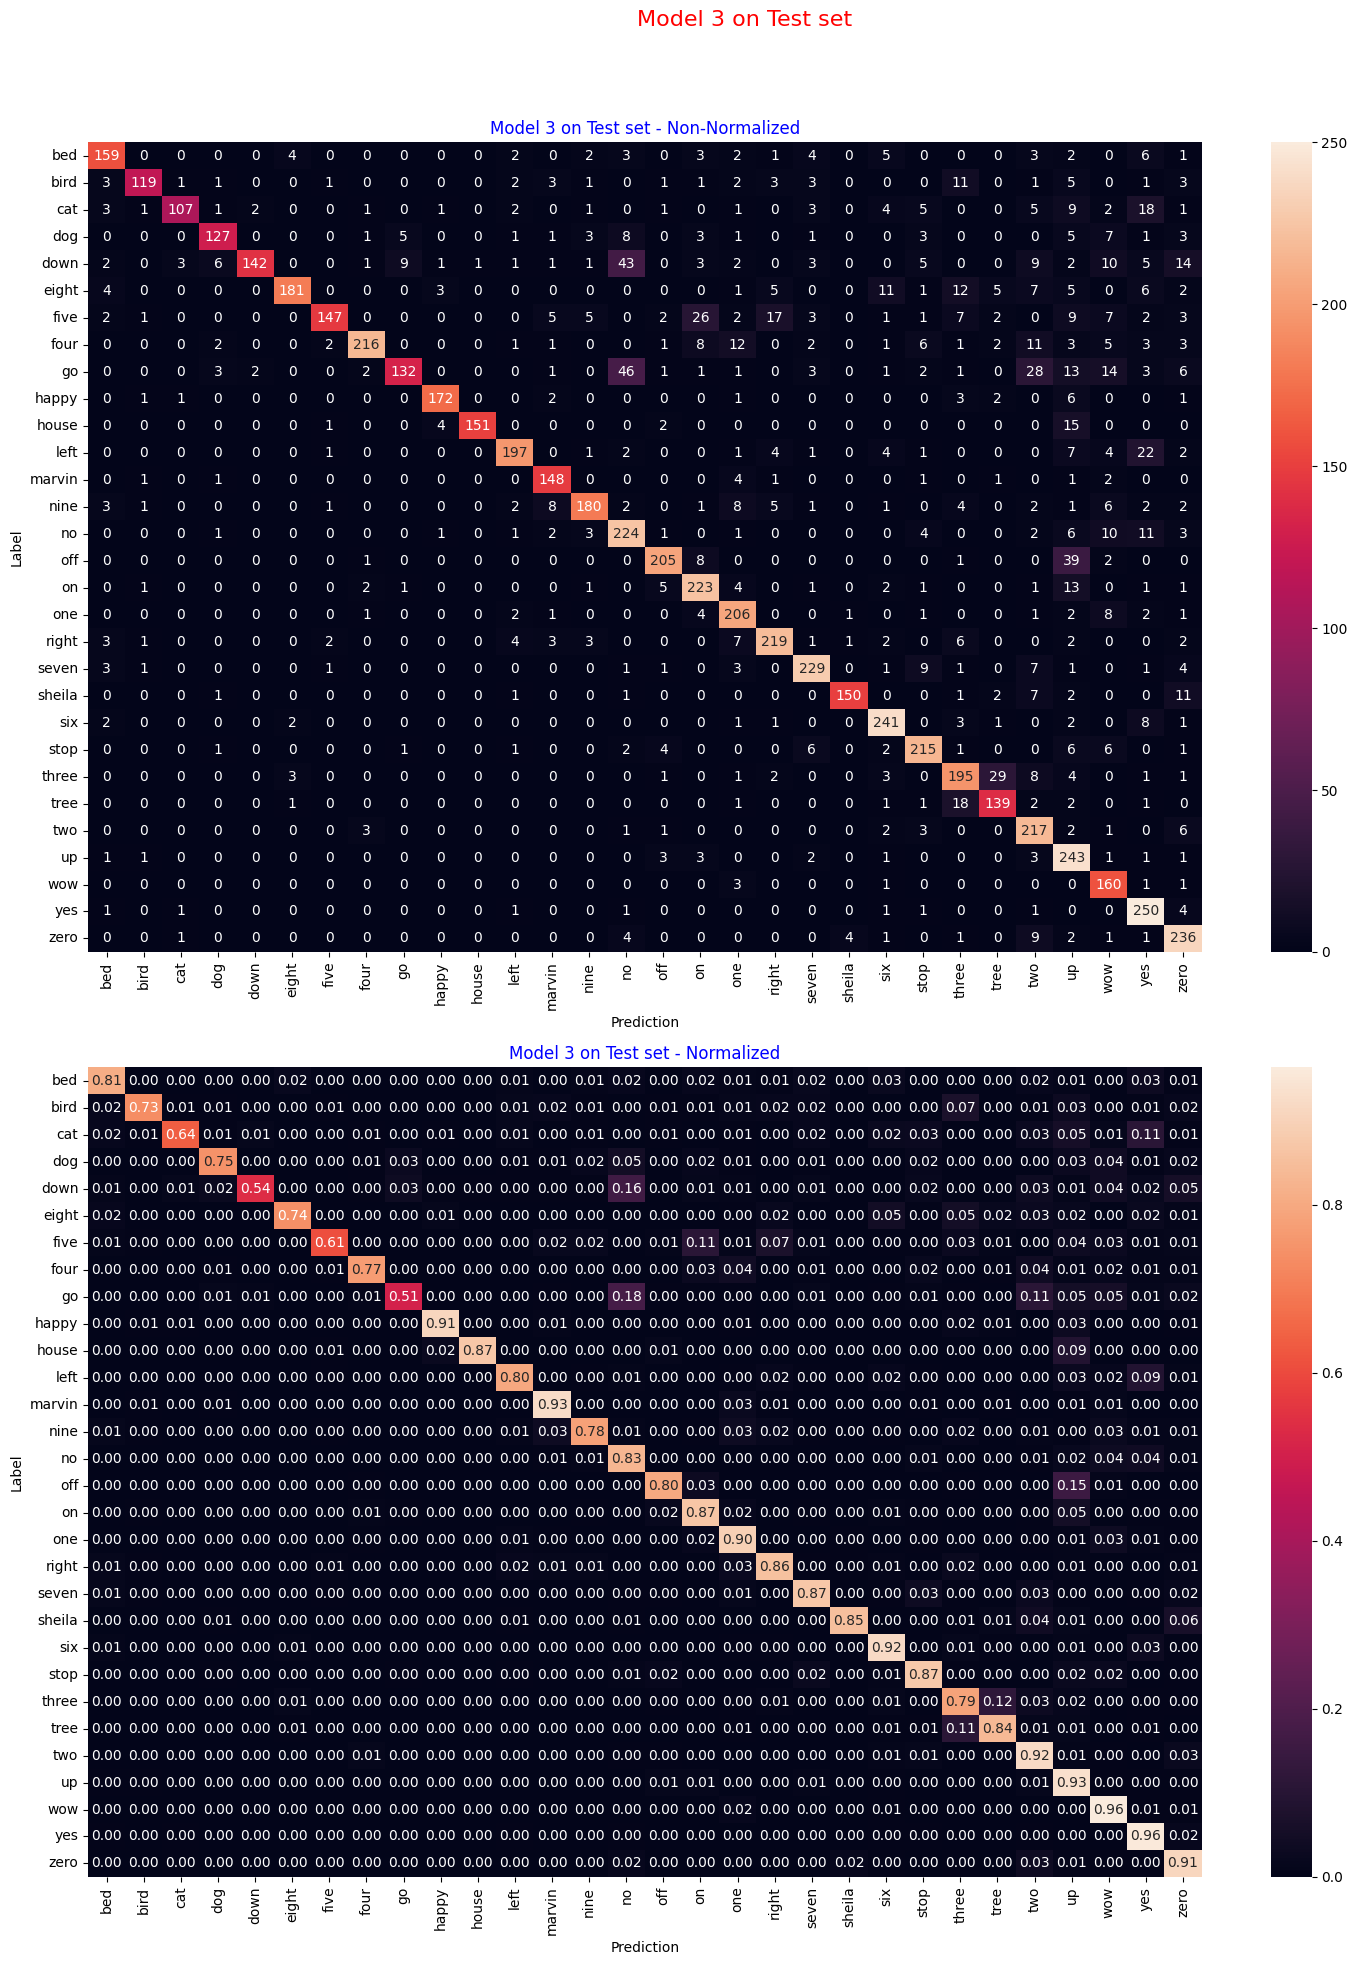

In [137]:
plot_confusion_matrix(model3, test_ds, class_list, title="Model 3 on Test set")

Again, we obtained a little improvement. But, we can do better.

## Model 4: "Dropout, more Filters and more parameters"

From the previous model we can see that despine Batch Normalization the model tends to overfit data. What we can try to do is to add some dropout in the final FC layer.

Moreover, it could be interesting to change a little bit our convolutional blocks with the purpose to increase the ability of the model to catch the features inside our input data.

In particular, we are going to increase the dimension of the output space of our first and second convolutional layers. While at the end of the network we are going to increase the number of parameters of the Dense Layer.

Thus, the architecture of Model 4 is going to be:

CONV -> BN -> ReLU -> MaxPool ->

CONV -> BN -> ReLU -> MaxPool ->

FC -> ReLU -> FC

In [142]:
# WE BATCH OUT TENSORFLOW DATASETS IF NECESSARY
if train_ds.element_spec[0].shape != (None, 20, 32, 1):
  train_ds = train_ds.batch(BATCH_SIZE)
if validation_ds.element_spec[0].shape != (None, 20, 32, 1):
  validation_ds = validation_ds.batch(BATCH_SIZE)
if test_ds.element_spec[0].shape != (None, 20, 32, 1):
  test_ds = test_ds.batch(BATCH_SIZE)

In [144]:
# MODEL4:
# CONV -> BN -> ReLU -> MaxPool ->
# CONV -> BN -> ReLU -> MaxPool ->
# FC -> ReLU -> FC

model4 = Sequential([
    Input(shape=INPUT_SHAPE),
    Resizing(TARGET_SHAPE[0], TARGET_SHAPE[1]),

    Conv2D(32, 3,  activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),

    Conv2D(64, 3,  activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(NUM_CLASSES, activation='softmax'),
])

In [145]:
model4.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_11 (Resizing)               │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 30, 30, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_20 (Activation)           │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 13, 13, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_21 (Activation)           │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 30)                  │           3,870 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 318,110 (1.21 MB)

 Trainable params: 317,918 (1.21 MB)

 Non-trainable params: 192 (768.00 B)

In [146]:
model4.compile(
    optimizer = tf.keras.optimizers.AdamW(),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy',
             tf.keras.metrics.F1Score(average='weighted', name='f1_score')],
)

In [147]:
model4_es = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                             min_delta=0.0001,
                                             verbose=1,
                                             patience=4,
                                             restore_best_weights=True)

In [148]:
EPOCHS = 50
history4 = model4.fit(
                      train_ds,
                      validation_data = validation_ds,
                      epochs = EPOCHS,
                      callbacks = model4_es
                      )

Epoch 1/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.4966 - f1_score: 0.4905 - loss: 1.6488 - val_accuracy: 0.4348 - val_f1_score: 0.3662 - val_loss: 2.1485
Epoch 2/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.6494 - f1_score: 0.6559 - loss: 1.1133 - val_accuracy: 0.6106 - val_f1_score: 0.5863 - val_loss: 1.2550
Epoch 3/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7542 - f1_score: 0.7600 - loss: 0.7788 - val_accuracy: 0.7018 - val_f1_score: 0.6906 - val_loss: 1.0106
Epoch 4/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8026 - f1_score: 0.8078 - loss: 0.6275 - val_accuracy: 0.7301 - val_f1_score: 0.7286 - val_loss: 0.9188
Epoch 5/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8285 - f1_score: 0.8336 - loss: 0.5366 - val_accuracy: 0.7284 - val_f1_score: 0.7274 - val_loss: 0.9205
Epoch 6/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8494 - f1_score: 0.8543 - loss: 0.4768 - val_accuracy: 0.7468 - val

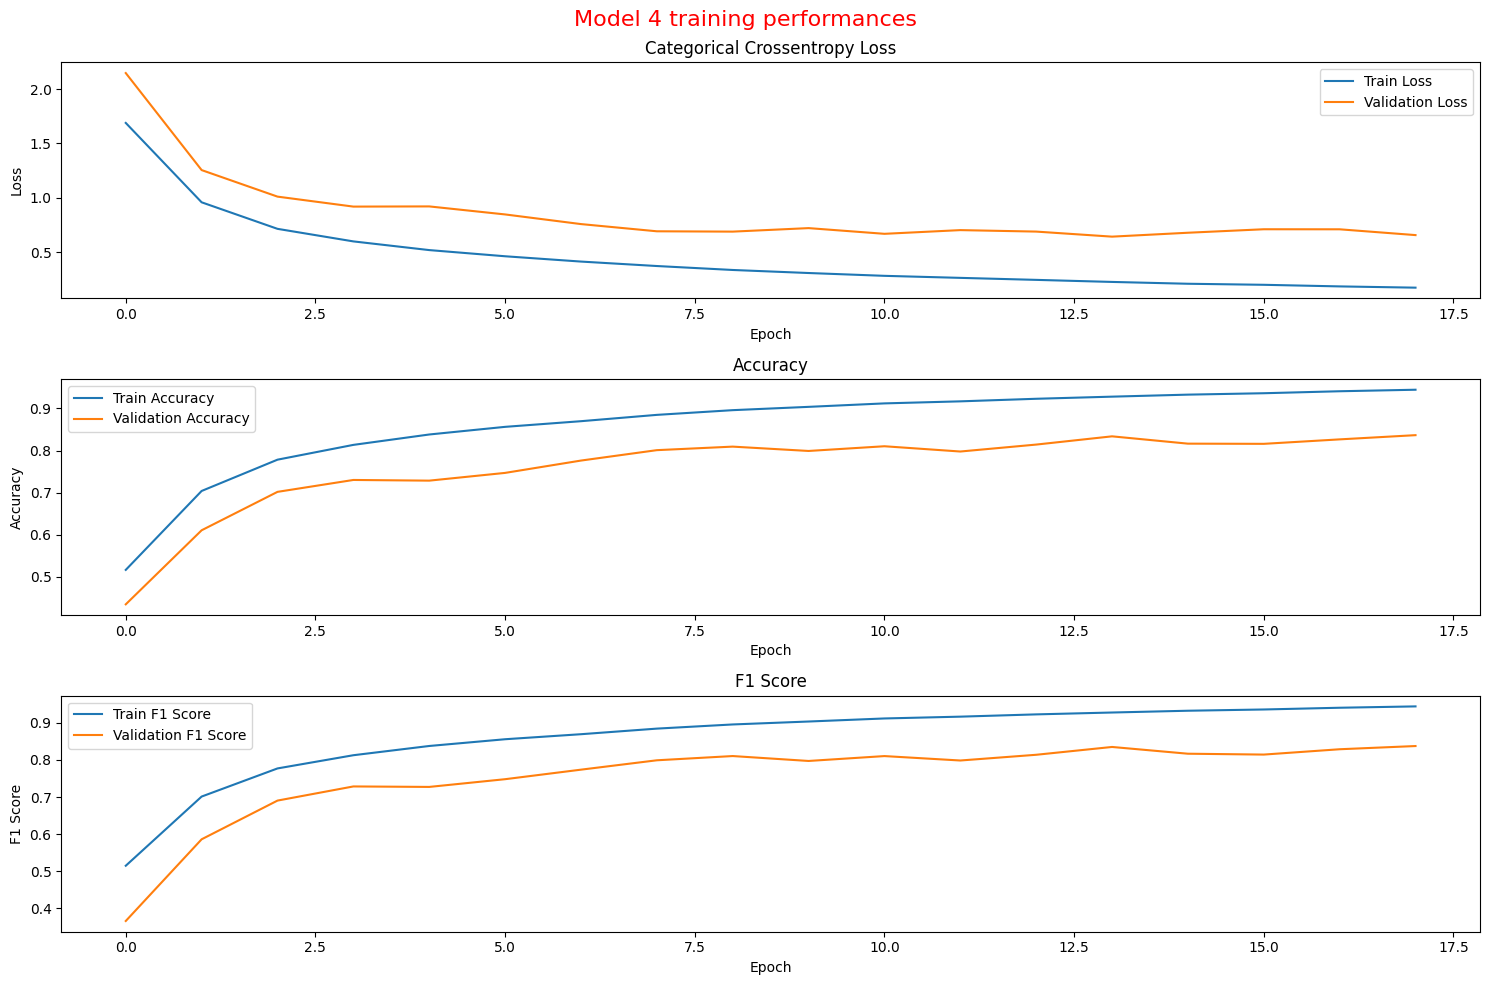

In [149]:
plot_model_history(history4, "Model 4 training performances")

In [150]:
model4_test_metrics = model4.evaluate(test_ds,
                                      verbose=2,
                                      return_dict=True)

213/213 - 1s - 3ms/step - accuracy: 0.8336 - f1_score: 0.8350 - loss: 0.6421


213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


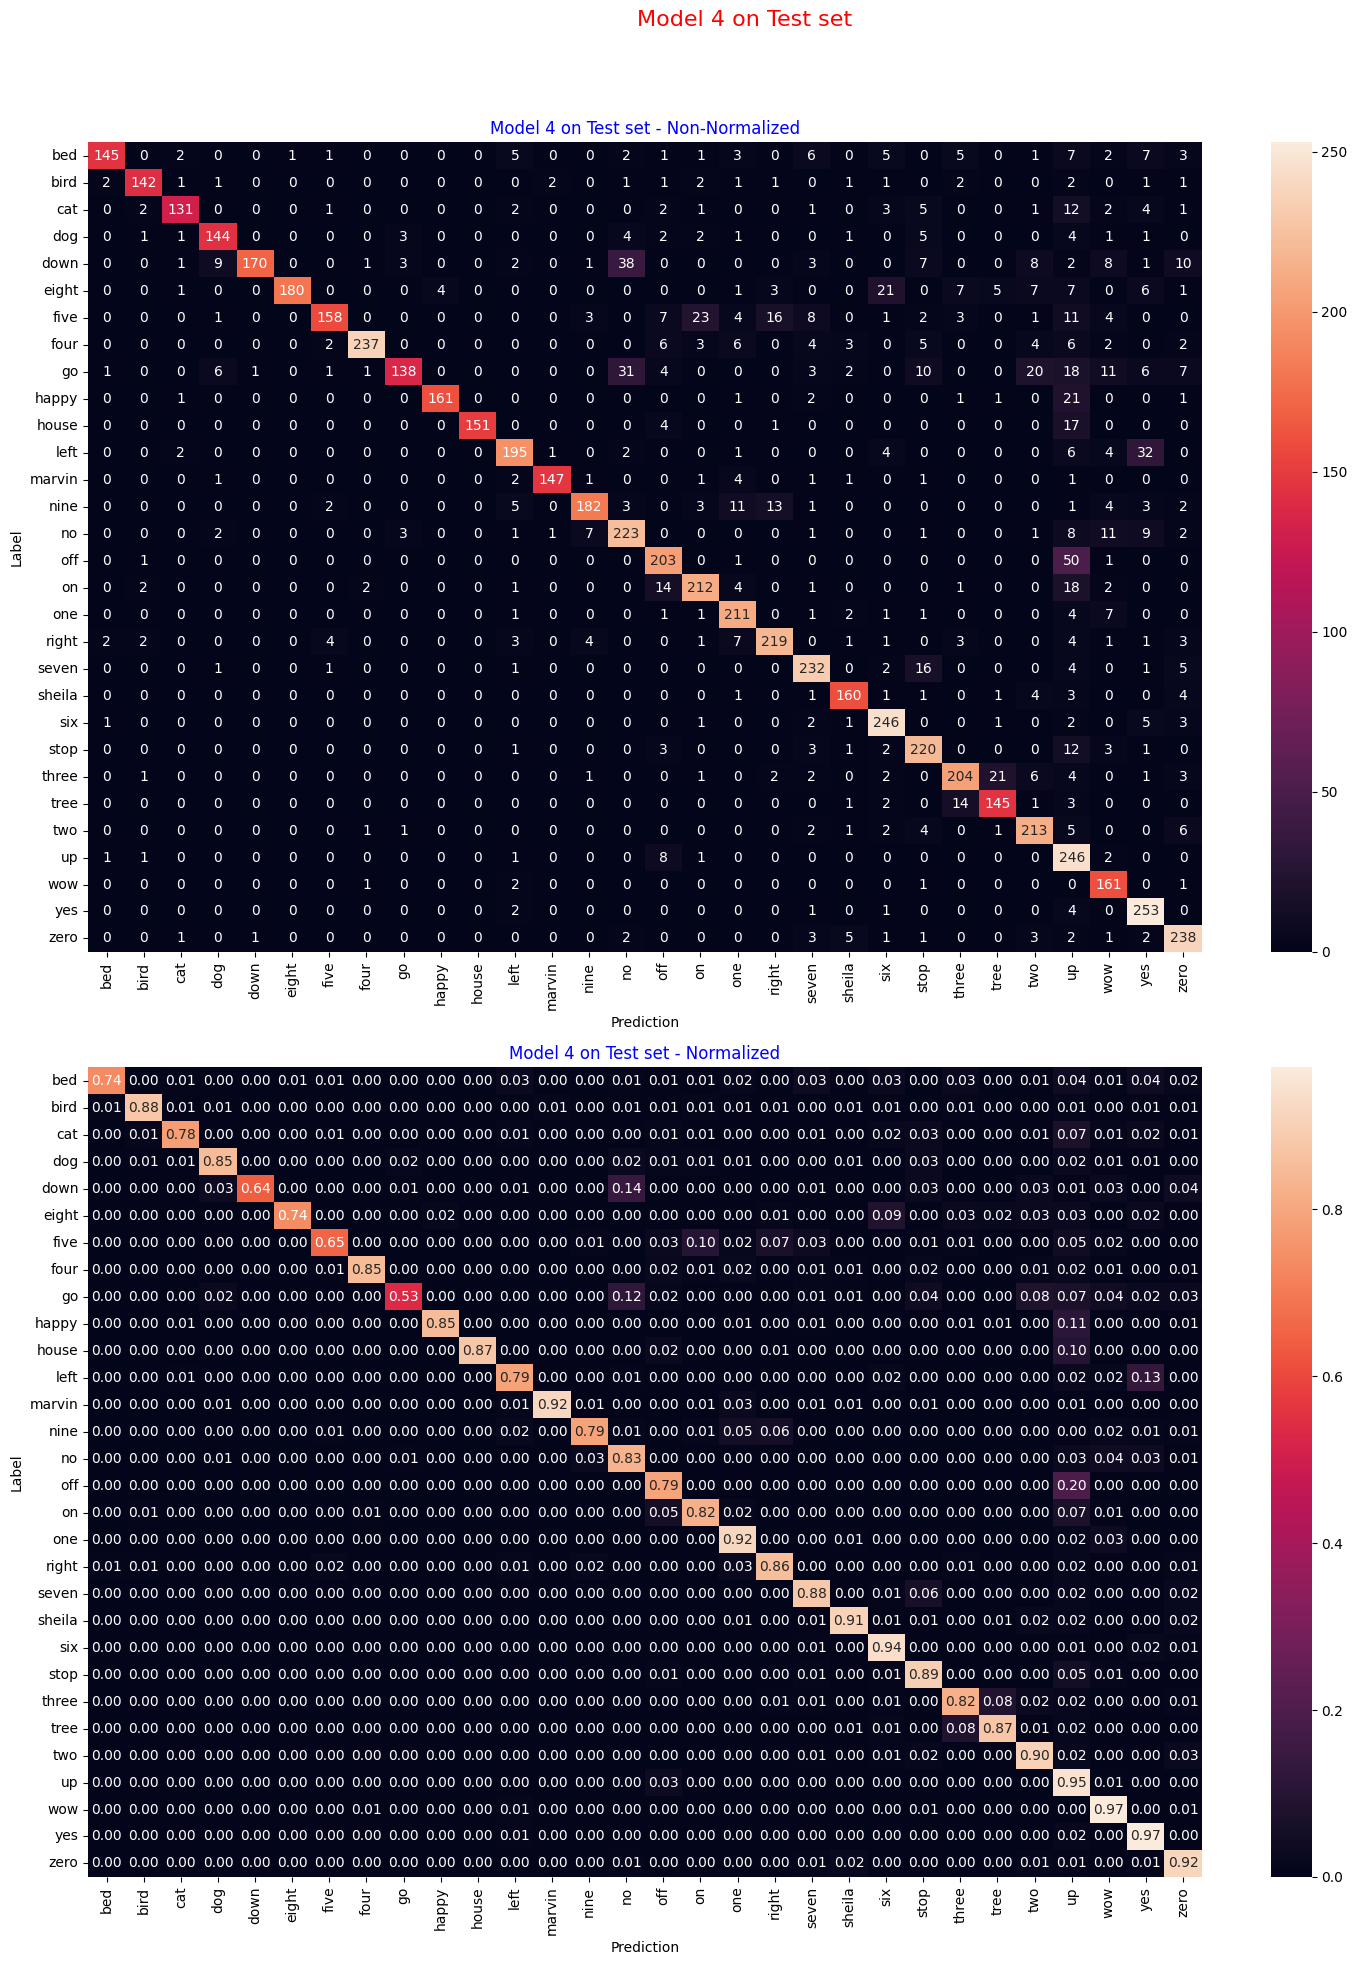

In [151]:
plot_confusion_matrix(model4, test_ds, class_list, title="Model 4 on Test set")

Not the great improvement we expected.

## Model 5: "deeper Convolutional Blocks"

In [179]:
# WE BATCH OUT TENSORFLOW DATASETS IF NECESSARY
if train_ds.element_spec[0].shape != (None, 20, 32, 1):
  train_ds = train_ds.batch(BATCH_SIZE)
if validation_ds.element_spec[0].shape != (None, 20, 32, 1):
  validation_ds = validation_ds.batch(BATCH_SIZE)
if test_ds.element_spec[0].shape != (None, 20, 32, 1):
  test_ds = test_ds.batch(BATCH_SIZE)

In [183]:
# MODEL5:
# CONV -> BN -> ReLU -> CONV -> BN -> ReLU -> MaxPool ->
# CONV -> BN -> ReLU -> CONV -> BN -> ReLU -> MaxPool ->
# FC -> ReLU -> Dropout -> FC

model5 = Sequential([
    Input(shape=INPUT_SHAPE),
    Resizing(TARGET_SHAPE[0], TARGET_SHAPE[1]),


    Conv2D(32, 3,  activation=None),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(32, 3,  activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),


    Conv2D(64, 3,  activation=None),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, 3,  activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    Dropout(0.2),
    Dense(NUM_CLASSES, activation='softmax'),
])

In [184]:
model5.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_16 (Resizing)               │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_42               │ (None, 30, 30, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_40 (Activation)           │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_43               │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_41 (Activation)           │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 12, 12, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_44               │ (None, 12, 12, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_42 (Activation)           │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 10, 10, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_45               │ (None, 10, 10, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_43 (Activation)           │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_16 (Flatten)                 │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 128)                 │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 30)                  │           3,870 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 274,558 (1.05 MB)

 Trainable params: 274,174 (1.05 MB)

 Non-trainable params: 384 (1.50 KB)

In [185]:
model5.compile(
    optimizer = tf.keras.optimizers.AdamW(),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy',
             tf.keras.metrics.F1Score(average='weighted', name='f1_score')],
)

In [186]:
model5_es = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                             min_delta=0.0001,
                                             verbose=1,
                                             patience=4,
                                             restore_best_weights=True)

In [187]:
EPOCHS = 50
history5 = model5.fit(
                      train_ds,
                      validation_data = validation_ds,
                      epochs = EPOCHS,
                      callbacks = model5_es
                      )

Epoch 1/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.5958 - f1_score: 0.5936 - loss: 1.3340 - val_accuracy: 0.5878 - val_f1_score: 0.5369 - val_loss: 1.4730
Epoch 2/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8084 - f1_score: 0.8146 - loss: 0.6326 - val_accuracy: 0.6692 - val_f1_score: 0.6533 - val_loss: 1.2111
Epoch 3/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8691 - f1_score: 0.8738 - loss: 0.4303 - val_accuracy: 0.7833 - val_f1_score: 0.7797 - val_loss: 0.7259
Epoch 4/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8968 - f1_score: 0.9000 - loss: 0.3333 - val_accuracy: 0.7289 - val_f1_score: 0.7248 - val_loss: 1.0228
Epoch 5/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9126 - f1_score: 0.9166 - loss: 0.2906 - val_accuracy: 0.8224 - val_f1_score: 0.8238 - val_loss: 0.6183
Epoch 6/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9240 - f1_score: 0.9275 - loss: 0.2450 - val_accuracy: 0.8241 - val_f

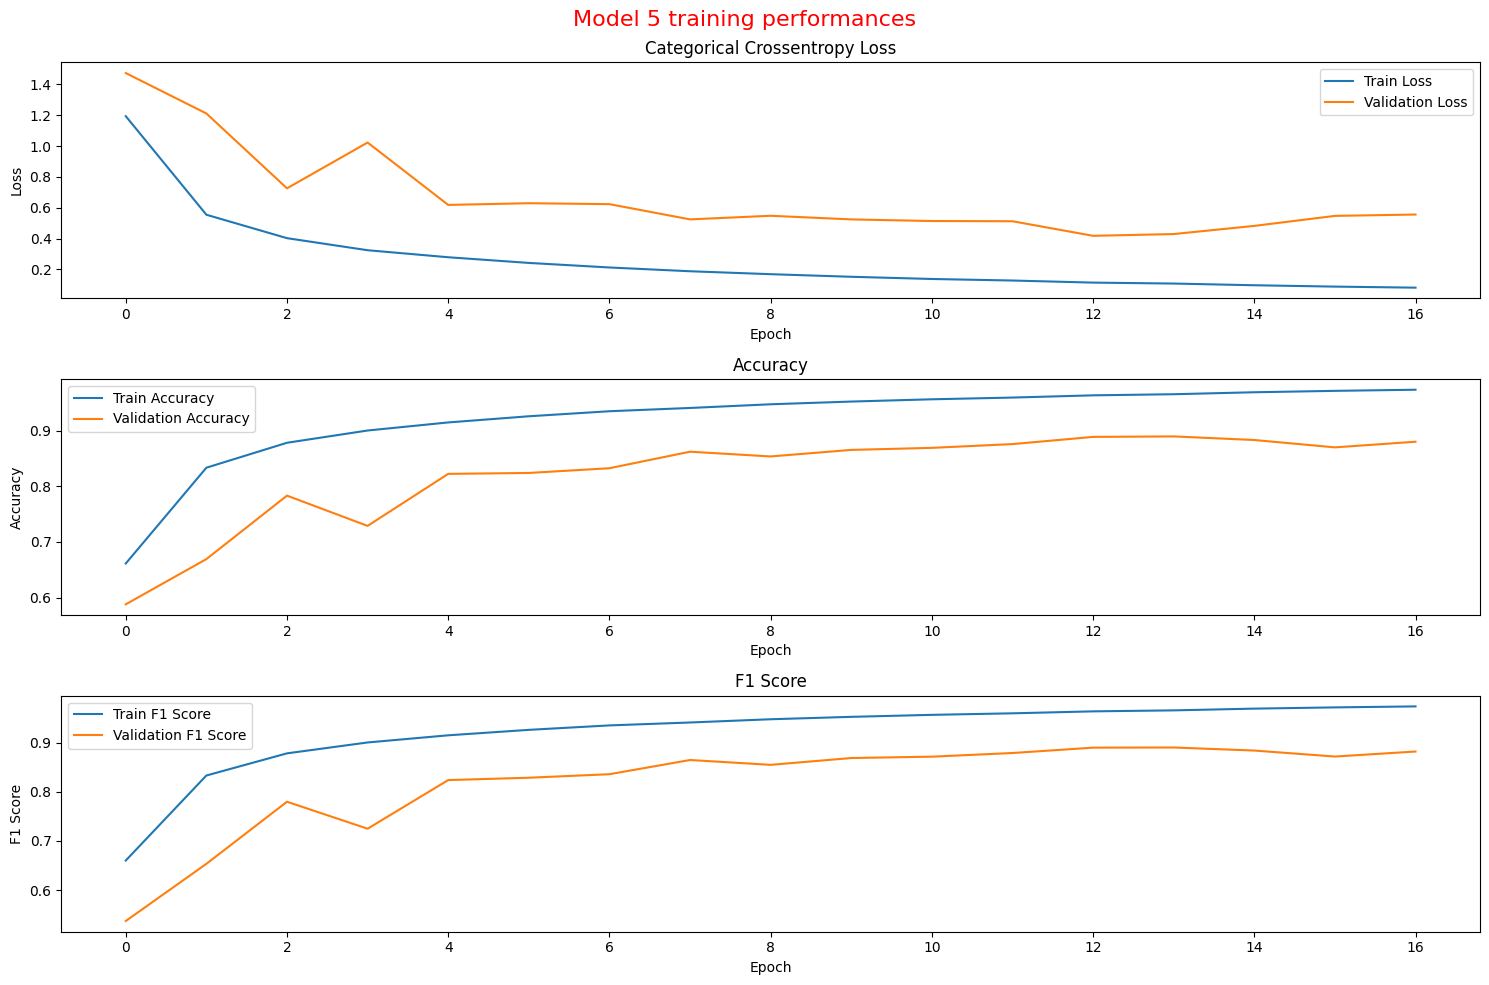

In [188]:
plot_model_history(history5, "Model 5 training performances")

In [189]:
model5_test_metrics = model5.evaluate(test_ds,
                                      verbose=2,
                                      return_dict=True)

213/213 - 1s - 5ms/step - accuracy: 0.8889 - f1_score: 0.8898 - loss: 0.4181


213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


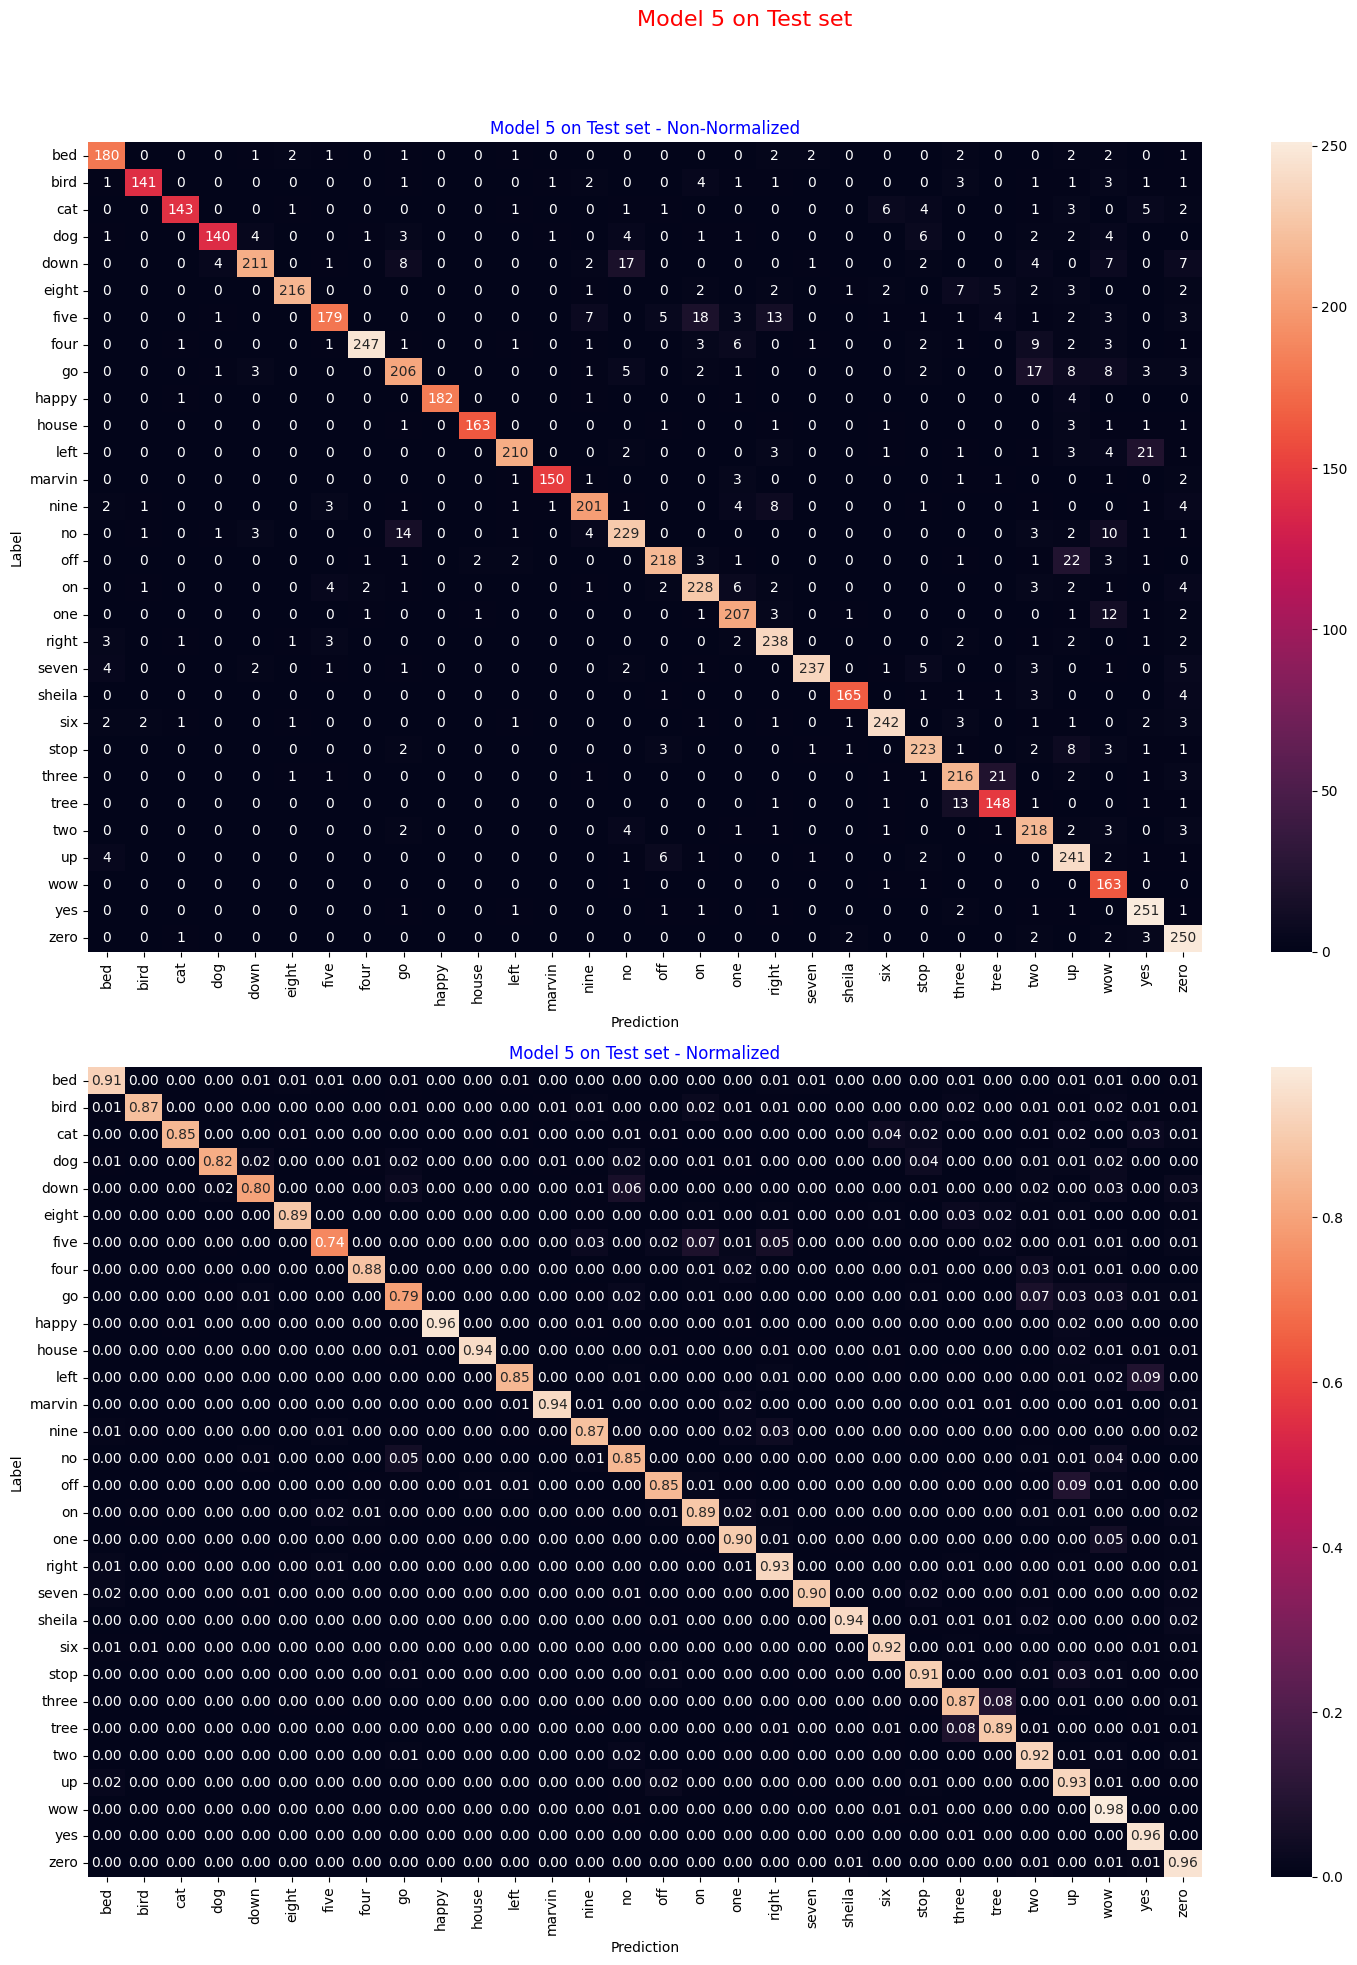

In [190]:
plot_confusion_matrix(model5, test_ds, class_list, title="Model 5 on Test set")

## Model 6

In [315]:
# WE BATCH OUT TENSORFLOW DATASETS IF NECESSARY
if train_ds.element_spec[0].shape != (None, 20, 32, 1):
  train_ds = train_ds.batch(BATCH_SIZE)
if validation_ds.element_spec[0].shape != (None, 20, 32, 1):
  validation_ds = validation_ds.batch(BATCH_SIZE)
if test_ds.element_spec[0].shape != (None, 20, 32, 1):
  test_ds = test_ds.batch(BATCH_SIZE)

In [316]:
model6 = Sequential([
    Input(shape=INPUT_SHAPE),
    Resizing(TARGET_SHAPE[0], TARGET_SHAPE[1]),


    Conv2D(32, 3,  activation=None),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(32, 3,  activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Dropout(0.2),


    Conv2D(64, 3,  activation=None),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, 3,  activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Dropout(0.2),


    Flatten(),
    Dense(128, activation=None, kernel_initializer='he_uniform'),
    Activation('relu'),
    Dropout(0.2),
    #Dense(256, activation='relu', kernel_initializer='he_uniform'),
    #Dropout(0.2),
    #Dense(128, activation='relu', kernel_initializer='he_uniform'),
    #Dropout(0.2),
    Dense(NUM_CLASSES, activation='softmax'),
])

In [317]:
model6.summary()

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_31 (Resizing)               │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_99 (Conv2D)                   │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_110              │ (None, 30, 30, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_108 (Activation)          │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_100 (Conv2D)                  │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_111              │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_109 (Activation)          │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_58 (MaxPooling2D)      │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_101 (Conv2D)                  │ (None, 12, 12, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_112              │ (None, 12, 12, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_110 (Activation)          │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_102 (Conv2D)                  │ (None, 10, 10, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_113              │ (None, 10, 10, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_111 (Activation)          │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_59 (MaxPooling2D)      │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_31 (Flatten)                 │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_71 (Dense)                     │ (None, 128)                 │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 274,558 (1.05 MB)

 Trainable params: 274,174 (1.05 MB)

 Non-trainable params: 384 (1.50 KB)

In [318]:
model6.compile(
    optimizer = tf.keras.optimizers.AdamW(),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy',
             tf.keras.metrics.F1Score(average='weighted', name='f1_score')],
)

In [319]:
model6_es = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                             min_delta=0.0001,
                                             verbose=1,
                                             patience=20,
                                             restore_best_weights=True)

In [ ]:
EPOCHS = 70
history6 = model6.fit(
                      train_ds,
                      validation_data = validation_ds,
                      epochs = EPOCHS,
                      callbacks = model6_es
                      )

Epoch 1/70
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - accuracy: 0.4825 - f1_score: 0.4778 - loss: 1.6773 - val_accuracy: 0.5235 - val_f1_score: 0.4632 - val_loss: 1.7343
Epoch 2/70
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7291 - f1_score: 0.7350 - loss: 0.8793 - val_accuracy: 0.6965 - val_f1_score: 0.6719 - val_loss: 0.9815
Epoch 3/70
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8303 - f1_score: 0.8353 - loss: 0.5506 - val_accuracy: 0.7748 - val_f1_score: 0.7721 - val_loss: 0.7453
Epoch 4/70
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8716 - f1_score: 0.8751 - loss: 0.4183 - val_accuracy: 0.8077 - val_f1_score: 0.8076 - val_loss: 0.6613
Epoch 5/70
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8914 - f1_score: 0.8947 - loss: 0.3517 - val_accuracy: 0.8273 - val_f1_score: 0.8261 - val_loss: 0.5983
Epoch 6/70
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9056 - f1_score: 0.9087 - loss: 0.3158 - val_accuracy: 0.8528 - val

In [ ]:
plot_model_history(history6, "Model 6 training performances")

In [ ]:
model6_test_metrics = model6.evaluate(test_ds,
                                      verbose=2,
                                      return_dict=True)

In [ ]:
plot_confusion_matrix(model6, test_ds, class_list, title="Model 6 on Test set")